# Online Portfolio Selection

- **Introduction**

    Online portfolio selection is a financial technology concept focusing on the design and implementation of algorithms to manage and optimize investment portfolios over time using online financial data.

    In finance, a portfolio refers to a collection of financial investments like stocks, bonds, commodities, cash, and cash equivalents, including closed-end funds and exchange-traded funds (ETFs). Investors aim to balance their portfolios based on their risk tolerance, investment goals, and time horizon to optimize their returns.

- **Our Goal**

    Study some strategies (specially Cover's Universal Portfolio and Exponenciated Gradient Strategy) and appleid them to historical data, backtesting them at the end. 

# Import Packages

In [1]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib as plt
import yfinance as yf
import pandas as pd
import string
import random

(CVXPY) Sep 16 08:06:44 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 16 08:06:44 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


# some parameters
- stock name
- start date
- end date
- $T$ = trading days between end and start date


In [2]:
#choose the stocks here
benchmark_asset = ['0050.TW']
benchmark_asset_name = ['0050.TW']
assets = ['2330.TW','2454.TW','2317.TW','2308.TW','2303.TW','2382.TW','2891.TW','2881.TW','3711.TW','2412.TW']
asset_name = ['2330.TW','2454.TW','2317.TW','2308.TW','2303.TW','2382.TW','2891.TW','2881.TW','3711.TW','2412.TW']

#choose the peroid of the investment
start="2013-01-01"
end="2024-03-15"

assets.sort()
asset_name.sort()

# stock datas
- This class is for the data of individual stock
- transform the data into a matrix form

Suppose we have $n$ stocks, and the price relative of the $i$-th stock for $t$ days is denoted by:

$$ {\bf r}_{i\cdot} = \begin{pmatrix} r_{i1} & r_{i2} & \cdots & r_{it} \end{pmatrix}^{tr} $$

Hence, we can obtain a matrix representing the price relative of $n$ stocks:

$$
\begin{pmatrix}
{\bf r}_{1\cdot} &
{\bf r}_{2\cdot} &
{\bf r}_{3\cdot} &
\cdots &
{\bf r}_{n\cdot}
\end{pmatrix}
=
\begin{pmatrix}
r_{11} & r_{21} & r_{31} & \cdots & r_{n1} \\
r_{12} & r_{22} & r_{32} & \cdots & r_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
r_{1t} & r_{2t} & r_{3t} & \cdots & r_{nt}
\end{pmatrix}
$$

The entry $r_{ij}$ means the price relative of the $i$-th stock at day $j$.

For convenience, we write:

$$
{\bf r}^{(t)} = {\bf r}_{\cdot t} = \begin{pmatrix} r_{1t} & r_{2t} & \cdots & r_{nt} \end{pmatrix}
$$

which means the price relative vector of day $t$.

Thus we may regard the matrix as:

$$
\begin{pmatrix}
r_{11} & r_{21} & r_{31} & \cdots & r_{n1} \\
r_{12} & r_{22} & r_{32} & \cdots & r_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
r_{1t} & r_{2t} & r_{3t} & \cdots & r_{nt}
\end{pmatrix}
=
\begin{pmatrix}
{\bf r}^{(1)} \\
{\bf r}^{(2)} \\
{\bf r}^{(3)} \\
\vdots \\
{\bf r}^{(t)}
\end{pmatrix}
$$




By similar arguments, we can obtain a weight matrix:

$$
\begin{pmatrix}
x_{11} & x_{21} & x_{31} & \cdots & x_{n1} \\
x_{12} & x_{22} & x_{32} & \cdots & x_{n2} \\
\vdots & \vdots & \vdots & \ddots & \cdots \\
x_{1t} & x_{2t} & x_{3t} & \cdots & x_{nt}
\end{pmatrix}
=
\begin{pmatrix}
{\bf x}^{(1)} \\
{\bf x}^{(2)} \\
{\bf x}^{(3)} \\
\vdots \\
{\bf x}^{(t)}
\end{pmatrix}
$$

The entry $x_{ij}$ means the weight of the $i$-th stock at day $j$, and we have the weight vector of day $t$.

$$
\bf{x}^{(t)} =
\begin{pmatrix} 
x_{1t} & x_{2t} & \cdots & x_{nt} 
\end{pmatrix}
$$

$\text{where} \sum_{i=1}^n x_{ij} = 1, \quad 0 \leq x_{ij} \leq 1, \quad \text{for all } j = 1, \ldots, t$


Having the price relative sequence $\{{\bf r}^{(i)}\}$ and weight sequence $\{{\bf x}^{(i)}\}$, we can compute the return of investment.

The return of investment from day $1$ to day $t$ is given by:

$$
W_{t}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\}) = \prod^{t}_{i=1} {\bf r}^{(i)} \cdot {\bf x}^{(i)}
$$

In [3]:
# Downloading data
data = yf.download(benchmark_asset+assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = benchmark_asset_name+asset_name
print(data)

# fill NAN
data.ffill()
for n in asset_name+benchmark_asset_name:
    data[n].fillna(method ='ffill',inplace = True)

# calculate the price relative
df = 1+data[benchmark_asset_name+asset_name].pct_change().dropna()
r = df[asset_name].to_numpy()
df = df.cumprod(axis=0)
print(df)

[*********************100%%**********************]  11 of 11 completed
               0050.TW    2303.TW     2308.TW     2317.TW     2330.TW  \
Date                                                                    
2013-01-02   38.443092   6.924152   74.271996   50.283920   71.122032   
2013-01-03   38.761101   7.246888   73.581100   50.510689   72.121750   
2013-01-04   38.513767   7.276227   72.890213   49.887089   72.478783   
2013-01-07   38.337097   7.158868   72.199295   49.206818   71.764694   
2013-01-08   38.089760   7.100190   71.853844   49.320183   71.193428   
...                ...        ...         ...         ...         ...   
2024-03-08  153.664795  49.163513  306.300690  102.375000  773.900452   
2024-03-11  152.122665  48.879330  302.373749  106.762505  756.132324   
2024-03-12  153.714539  49.731876  306.791565  116.025002  760.080872   
2024-03-13  154.460724  50.205513  308.755005  117.487503  768.964905   
2024-03-14  154.311493  49.826603  304.828094  117.97

C:\Users\林元鴻\AppData\Local\Temp\ipykernel_22852\1880493607.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[n].fillna(method ='ffill',inplace = True)


In [4]:
print(df.columns)

Index(['0050.TW', '2303.TW', '2308.TW', '2317.TW', '2330.TW', '2382.TW',
       '2412.TW', '2454.TW', '2881.TW', '2891.TW', '3711.TW'],
      dtype='object')


Text(0, 0.5, 'return ratio')

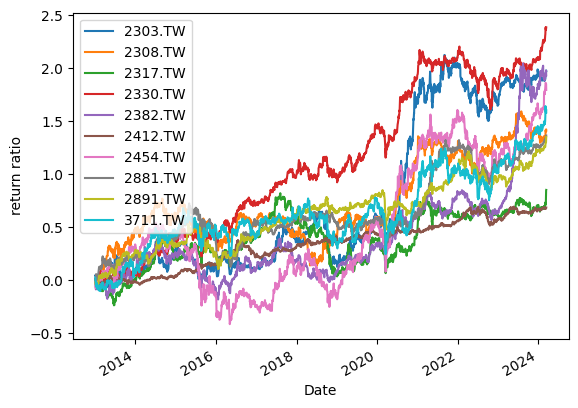

In [5]:
ax = np.log(df[asset_name]).plot()
ax.set_ylabel("return ratio")

In [6]:
# calculate the return with commission
def pay_fee_period(r,weight,period,buy_fee = 0.001425,sell_fee = 0.001425+0.003):
  '''input:  r : related prices
     weight: weight metrix
     period: rebalence period
    交易成本比照台股: 買:0.1425%
                    賣:0.1425%+0.3%
    output: result -> np_array shape(T*1) '''
  t = 0
  fee = (buy_fee+sell_fee)/2
  result = np.zeros(r.shape[0])
  result[0] = np.dot(r[0],weight[0])
  now = r[0]*weight[0]
  now = now/sum(now)
  t+=1
  for i in range(1,period):
    now = now*r[t]
    result[t] = sum(now)
    now = now/sum(now)
    t+=1
  for i in range(1,weight.shape[0]-1):
    x = weight[i]
    diff_val = np.linalg.norm(now-x,1)*fee
    x = x-(weight[i]*diff_val)
    now = r[i]*x
    result[t] = sum(now)
    now=now/sum(now)
    t+=1
    for j in range(1,period):
      now = now*r[t]
      result[t] = sum(now)
      now = now/sum(now)
      t+=1
  for i in range(t,r.shape[0]):
    now = now*r[i]
    result[i] = sum(now)
    now = now/sum(now)
  return result

# Buy and Hold

Buy and Hold ($BAH$) strategy is to buy the stocks at day $1$ and sell them at day $T$.

Here we choose the equal weight $\mathbf{x} = \begin{pmatrix} \frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n} \end{pmatrix}$.

- **Adventages**

    - Reduced Costs: 

        Fewer transactions mean lower brokerage fees and fewer taxable events, which can erode investment returns.

- **Considerations**

    -  Market Risk:

        While the market generally trends upwards over the long term, there are no guarantees, and there can be prolonged periods of stagnation or decline.

In [7]:
class BAH:
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)'''
    self.r = r
    self.t = 0
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.period = 1
  def run(self):
    self.weight[0] = np.ones(r.shape[1])/r.shape[1]
    for time in range(1,self.r.shape[0]):
      x = self.r[time]*self.weight[self.t]
      self.weight[time] = x/sum(x)
      self.t+=1
    return

Text(0, 0.5, 'return ratio')

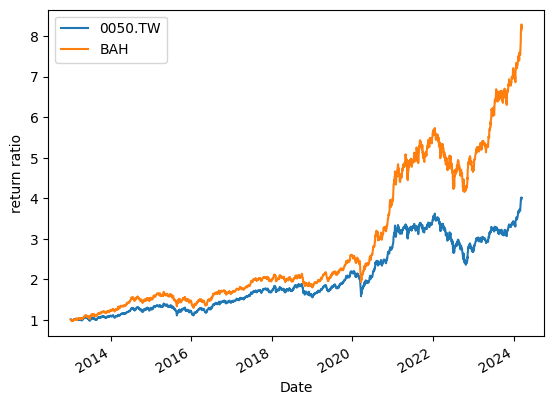

In [8]:
bah = BAH(r)
bah.run()
df['BAH'] = np.cumprod(np.sum(np.multiply(r,bah.weight), axis=1))
ax = df[benchmark_asset_name+['BAH']].plot()
ax.set_ylabel("return ratio")

# Constant Rebalanced Portfolio (CRP)

The Constant Rebalanced Portfolio ($CRP$) is an investment strategy focused on maintaining a fixed weight of different assets in a portfolio, i.e.

$$
{\bf x} = {\bf x}^{(1)} = {\bf x}^{(2)} = \cdots = {\bf x}^{(n)}
$$

- **Special cases of $CRP$**

    - Uniform Constant Rebalanced Portfolio ($UCRP$):

        Each stock is equally weighted, i.e.

        $$
        {\bf x} = \begin{pmatrix} \frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n} \end{pmatrix}
        $$

    - Best Constant Rebalanced Portfolio ($BCRP$):

        Find a weight vector such that the return is maximized, i.e.

        $$
        {\bf x}^{*} = \arg\max_{{\bf x} \in \Delta_{n}}\{\prod_{i=1}^T {\bf r}^{(i)} \cdot {\bf x}\}
        $$

        where $\Delta_{n} = \{{\bf x} \in \mathbb{R}^n | \sum_{i=1}^n x_{i}=1 , 0 \leq x_{i} \leq 1 \}$

        Note that $BCRP$ strategy requires the knowledgement of future.

- **Advantages**

    - Risk Control: 
        
        Maintains a consistent risk profile by ensuring that the asset allocation doesn’t drift over time.

- **Considerations**

    - Transaction Costs:

        Frequent rebalancing can incur transaction fees and taxes, which might impact overall returns.

    - Not Optimized for Short-Term:

        $CRP$ is generally more suited for long-term investing, as short-term market fluctuations are less relevant to the strategy.


In [9]:
class UCRP():
    def __init__(self, r):
        # r is the price relative matrix
        self.r = r
        self.weight = np.ones((r.shape[0],r.shape[1]))/r.shape[1]
        self.period = 1

Text(0, 0.5, 'return ratio')

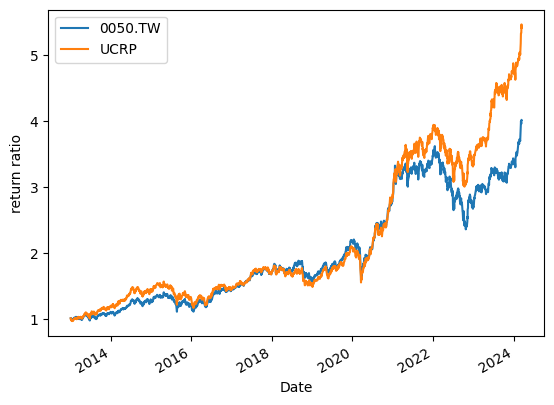

In [10]:
ucrp = UCRP(r)
df['UCRP'] = np.cumprod(pay_fee_period(r,ucrp.weight,ucrp.period))
ax = df[benchmark_asset_name+['UCRP']].plot()
ax.set_ylabel("return ratio")

In [11]:
class BCRP:
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)'''
    self.r = r
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.period = 1
  def bcrp(self,T):
    if T == range(0):
      return np.ones(self.n)/self.n

    x = cp.Variable(self.n)

    obj = cp.sum(cp.log(self.r[T]@x))
    prob = cp.Problem(cp.Maximize(obj), [cp.sum(x) == 1, x >= 0])
    prob.solve()
    return x.value
  def run(self):
    x = self.bcrp(range(r.shape[0]))
    for i in range(r.shape[0]):
      self.weight[i] = x
    return

Text(0, 0.5, 'return ratio')

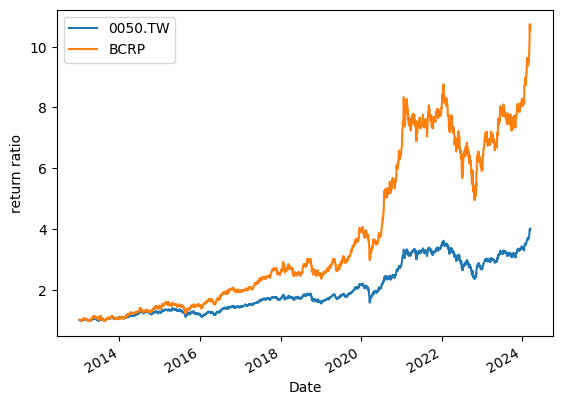

In [12]:
bcrp = BCRP(r)
bcrp.run()
df['BCRP'] = np.cumprod(pay_fee_period(r,bcrp.weight,1))
ax = df[benchmark_asset_name+['BCRP']].plot()
ax.set_ylabel("return ratio")

# Follow The Leader

Follow The Leader ($FTL$) strategy is that the weight vector of day $t$ is equal to the BEST performed portfolio from day $1$ to day $t-1$ 

The BEST performed portfolio is chosen by $BCRP$, i.e.

$$
\begin{align*}
{\bf x}^{(t)} &= \arg\max_{{\bf x} \in \Delta_{n}}\{\prod_{i=1}^{t-1} {\bf r}^{(i)} \cdot {\bf x}\} \quad \forall t \geq 2
\\
{\bf x}^{(1)} &= 
\begin{pmatrix}
\frac{1}{n} & \frac{1}{n} & \cdots & \frac{1}{n}
\end{pmatrix} 
\end{align*}
$$

- **Adventages**

    - Potential for High Returns: 
        
        If the leaders are consistently successful, following their lead could potentially result in high returns.

- **Considerations**

    - Incomplete Information: 
    
        Public disclosures and media reports may not provide a complete picture of an investment strategy. Leaders might have complex strategies that aren't fully visible or understandable to outsiders.

In [13]:
# datarange = 100days, for convinient，assume the weight vector today oonly depends on privious 100 days 
class FTL(BCRP):
  def __init__(self, r):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period
      datarange = number of day in order to determine weight of last day'''
    self.r = r
    self.n = r.shape[1]
    self.weight = np.zeros((r.shape[0],self.n))
    self.datarange = 10
    self.period = 1
  def run(self):
    for time in range(self.r.shape[0]):
      if time<self.datarange:
        x = super().bcrp(range(time))
      else:
        x = super().bcrp(range(time-self.datarange,time))
      self.weight[time] = x
    return

In [14]:
# ftl = FTL(r)
# ftl.run()
# df['FTL'] = np.cumprod(pay_fee_period(r,ftl.weight,1))
# ax = df[benchmark_asset_name+['BCRP']+['FTL']].plot()
# ax.set_ylabel("return ratio")

# Universal Portfolio

First, for each weight vector ${\bf x} \in \Delta_{n}$, we consider:

$$
W_{t-1}({\bf x})=\prod_{i=1}^{t-1} {\bf r}^{(i)} \cdot {\bf x} \quad \forall t \geq 2
$$

which means we assign a higher weight if the performance of the portfolio is better.

Second, weight vector of day $t$ using the $UP$ strategy is the function given by:
$$
{\bf x}^{(t)}=
\frac{\int_{{\bf x} \in \Delta_{n}} {\bf x} \cdot W_{t-1}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}}W_{t-1}({\bf x})d \mu ({\bf x})} \quad \forall t \geq 2
$$

The initial weight vector is given by:

$$
{\bf x}^{(1)}=
\begin{pmatrix}
\frac{1}{n}&
\frac{1}{n}&
\cdots&
\frac{1}{n}
\end{pmatrix}
$$

where $\mu$ is the uniform distribution or dirichlet distribution over $n$-simplex $\Delta_{n}$.

- **Adventages**

    - Potential for High Performance: 

        In theory, the strategy can outperform many traditional approaches by intelligently adapting to market trends.

- **Considerations**

    - Complexity: 
    
        Requires sophisticated algorithms and often extensive computational resources.


# Analysis of UP

- **THEOREM**

  If we choose $\mu({\bf x})$ as uniform distribution, and let $\{\hat{\bf x}^{(i)}\}$ be the weight sequence obtain from $UP$ algoritm, then:

  $$
  \begin{align*}
  \frac{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})}{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})} &\leq (T+1)^{n-1}
  \\
  \text{or}
  \\
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}) &\leq (n-1)\log(T+1)
  \end{align*}
  $$

  where $T$ is the time of investment and $n$ is the number of stocks.

  The above theorem says that the difference of the log return of $UP$ and $BCRP$ is bounded by $(n-1)\log(T+1)$.

- **Proof:**

  **Settings:**

  Let $\{{\bf u}\}$ be the weight sequence choosen by $CRP$ strategy, where ${\bf u} \in \Delta_{n}$.

  We denote $\{{\bf x}^{*}\}$ as the weight sequence choosen by $BCRP$ strategy, where ${\bf x}^{*} \in \Delta_{n}$.

  **Idea:**

  The idea behind our argument is that portfolios “near” to each other perform similarly and that a large fraction of portfolios are “near” the optimal portfolio.

  Here is what we mean when we say that “near” portfolios ${\bf x}$ perform nearly as well as ${\bf x}^{*}$:

  ${\bf x} = (1-\alpha){\bf x}^{*} + \alpha{\bf w}$ for some ${\bf w} \in \Delta_{n}$

  **Step 1:**

  First, from the $UP$ algorithm, we can directly obtain:

  $$
  \begin{align*}
  W(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})&=\prod^{t}_{i=1} {\bf r}^{(i)} \cdot \hat{{\bf x}}^{(i)} = \prod^{t}_{i=1} \frac{\int_{{\bf x} \in \Delta_{n}} {\bf r}^{(i)} \cdot {\bf x} \cdot W_{i-1}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}}W_{i-1}({\bf x})d \mu ({\bf x})} = \prod^{t}_{i=1} \frac{\int_{{\bf x} \in \Delta_{n}} W_{i}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} W_{i-1}({\bf x})d \mu ({\bf x})}
  \\
  &=\frac{\int_{{\bf x} \in \Delta_{n}} \prod^{t}_{i=1} W_{i}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} \prod^{t}_{i=1} W_{i-1}({\bf x})d \mu ({\bf x})} = \frac{\int_{{\bf x} \in \Delta_{n}} W_{t}({\bf x})d \mu ({\bf x})}{\int_{{\bf x} \in \Delta_{n}} 1 \, d \mu ({\bf x})} = E_{{\bf x} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf x}\})]
  \end{align*}
  $$

  Hence 

  $$
  {W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})=E_{{\bf x} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf x}\})] \quad -(1)
  $$

  Second, consider ${\bf x} = (1-\alpha){\bf x}^{*} + (\alpha){\bf w}$, for some ${\bf w} \in \Delta_{n}$ we have:

  $$
  \text{Single period's} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}\}) \geq (1-\alpha) \, \text{Single period's} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})
  $$

  After all, compiled over $T$ periods, we obtain:

  $$
  {W}(\{{\bf r}^{(i)}\},\{{\bf x}\}) \geq (1-\alpha)^{T} \, {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\}) \quad - (2)
  $$

  Third, we will show that a sufficiently large volume of portfolios is sufficiently near ${\bf x}^{*}$.

  Note that the $n$-simplex is $(n-1)$-dimensional, hence we have:

  $$
  Vol_{n-1}(\{(1-\alpha){\bf x}^{*}+\alpha{\bf z} | {\bf z} \in \Delta_{n}\}) = Vol_{n-1}(\{\alpha{\bf z} | {\bf z} \in \Delta_{n}\}) = \alpha^{n-1} Vol_{n-1}(\Delta_{n}) \quad - (3)
  $$ 

  **Step 2:**

  If we consider $\alpha$ as a random variable defined by $1-\alpha = \underset{j}{min} \{\frac{{\bf x}_{j}}{{\bf x}^{*}_{j}}\}$, then from $(1)$ and $(2)$ in Step $1$ we have:

  $$
  \frac{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})}{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} \geq \frac{E_{{\bf z} \in \Delta_{n}}[{W}(\{{\bf r}^{(i)}\},\{{\bf z}\})]}{(1-\alpha)^{-T} {W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} = E_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T}\right] = \int^{1}_{0} \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right]dx
  $$

  **Step 3:**

  By $(3)$

  $$
  \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right] = \text{Prob}_{{\bf z} \in \Delta_{n}}\left[1-x^{\frac{1}{T}} \leq \alpha \right] = (1-x^{\frac{1}{T}})^{n-1}
  $$

  hence:

  $$
  \frac{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})}{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})} \geq \int^{1}_{0} \text{Prob}_{{\bf z} \in \Delta_{n}}\left[(1-\alpha)^{T} \geq x\right]dx = \int^{1}_{0} (1-x^{\frac{1}{T}})^{n-1} dx
  $$ 

  Let $y = x^{\frac{1}{T}}$ and repeating integration by parts, this yields:

  $$
  \begin{align*}
  \int^{1}_{0} (1-x^{\frac{1}{T}})^{n-1} dx &= T\left(\int^{1}_{0} y^{T-1}(1-y)^{n-1} dy\right) = T\left(\frac{n-1}{T} \int^{1}_{0} y^{T}(1-y)^{n-2} dy\right)
  \\
  &= T\left(\frac{n-1}{T} \frac{n-2}{T+1} \int^{1}_{0} y^{T+1}(1-y)^{n-3} dy\right) = \cdots = T\left(\frac{(n-1)!(T-1)!}{(T+n-2)!} \int^{1}_{0} y^{T+n-2} dy\right) = \begin{pmatrix} T+n-1 \\ n-1 \end{pmatrix}^{-1}
  \end{align*}
  $$

  Thus we have:

  $$
  \frac{{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})}{{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})} \leq 
  \begin{pmatrix} 
  T+n-1 \\ 
  n-1 
  \end{pmatrix} 
  \leq (T+1)^{n-1}
  \quad \Box
  $$
  
- **Corollary:**

  $$
  \lim_{T \to \infty} \underset{\{{\bf r}^{(i)}\}}{max}\{\frac{1}{T}(\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}))\} \leq 0
  $$

  That is, $UP$ algorithm exhibits the same asymptotic growth rate in normalized logrithmic return as the $BCRP$ for any sequence of price relatives $\{{\bf r}^{(i)}\}$.

  - **proof**

    By Theorem, we have:

    $$
    \log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}) \leq (n-1)\log(T+1)
    $$

    for any price relative sequence $\{{\bf r}^{(i)}\}$

    which implies:

    $$
    \underset{\{{\bf r}^{(i)}\}}{max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\})\} \leq (n-1)\log(T+1)
    $$

    Divides both sides by T, we obtain:

    $$
    \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{max}\{(\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}))\} \leq \frac{(n-1)\log(T+1)
    }{T}
    $$

    Letting $T \to \infty$, and apply L'Hospital's Rule:
    
    $$
    \lim_{T \to \infty} \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{max}\{(\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{*}\})-\log{W}(\{{\bf r}^{(i)}\},\{\hat{\bf x}^{(i)}\}))\} \leq \lim_{T \to \infty}\frac{(n-1)\log(T+1)}{T}=\lim_{T \to \infty}\frac{n-1}{T+1}=0 \quad \Box
    $$


In [15]:
# use Monte Carlo method to estimate the result of integral
class UP_uniform:
  def __init__(self, r,period, eval_points=1e4):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period'''
    self.eval_points = int(eval_points)
    self.period = period
    self.n = r.shape[1]
    self.t = 1
    self.weight = np.array([np.ones(r.shape[1])/r.shape[1]])
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def mc_simplex(self,d, points):
    """Sample random points from a simplex with dimension d.
    :param d: Number of dimensions.
    :param points: Total number of points.
    """
    a = np.sort(np.random.random((points, d)))
    a = np.hstack([np.zeros((points, 1)), a, np.ones((points, 1))])
    return np.diff(a)

  def init_step(self):
    """Create a mesh on simplex and keep wealth of all strategies."""
    # create set of CRPs
    self.W = np.matrix(self.mc_simplex(self.n-1, self.eval_points))
    self.S = np.matrix(np.ones(self.W.shape[0])).T


  def step(self):
    # calculate new wealth of all CRPs
    self.S = np.multiply(self.S, self.W * np.matrix(self.r[self.t]).T)
    b = self.W.T * self.S
    self.t+=1
    return b / sum(b)

  def run(self):
    self.init_step()
    for i in range(self.r.shape[0]-1):
      arr = self.step().T
      self.weight = np.vstack((self.weight,arr))
    self.weight = np.array(self.weight)
    return

Text(0, 0.5, 'return ratio')

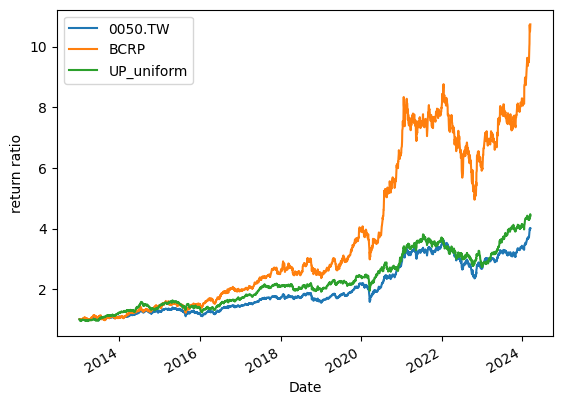

In [16]:
up_uniform = UP_uniform(r,3)
up_uniform.run()
df['UP_uniform'] = np.cumprod(pay_fee_period(r,up_uniform.weight,up_uniform.period))
ax = df[benchmark_asset_name+['BCRP']+['UP_uniform']].plot()
ax.set_ylabel("return ratio")

In [17]:
from scipy.stats import dirichlet
class UP_dirichlet:
  def __init__(self, r,period = 1, eval_points=1e4):
    '''r = 'return' (T*n np_matrix)
      weight = weight for every days and every stocks (T*n np_matrix)
      period: rebalence period'''
    self.n = r.shape[1]
    self.alpha = np.ones(self.n)/2
    self.eval_points = int(eval_points)
    self.period = period
    self.t = 1
    self.weight = np.array([np.ones(r.shape[1])/r.shape[1]])
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def mc_simplex(self,d, points):
    """Sample random points from a simplex with dimension d.
    :param d: Number of dimensions.
    :param points: Total number of points.
    """
    a = np.sort(np.random.random((points, d)))
    a = np.hstack([np.zeros((points, 1)), a, np.ones((points, 1))])
    return np.diff(a)

  def init_step(self):
    """Create a mesh on simplex and keep wealth of all strategies."""
    # create set of CRPs
    self.W = np.matrix(self.mc_simplex(self.n-1, self.eval_points))
    self.x = np.matrix([dirichlet.pdf(np.array(y)[0],self.alpha) for y in self.W]).T
    # self.W = np.multiply(self.W,x)
    self.S = np.matrix(np.ones(self.W.shape[0])).T


  def step(self):
    # calculate new wealth of all CRPs
    self.S = np.multiply(self.S, self.W * np.matrix(self.r[self.t]).T)
    b = np.multiply(self.W,self.x).T * self.S
    self.t+=1
    # print(self.S)
    return b / sum(b)

  def run(self):
    self.init_step()
    for i in range(self.r.shape[0]-1):
      arr = self.step().T
      self.weight = np.vstack((self.weight,arr))
    self.weight = np.array(self.weight)
    return


Text(0, 0.5, 'return ratio')

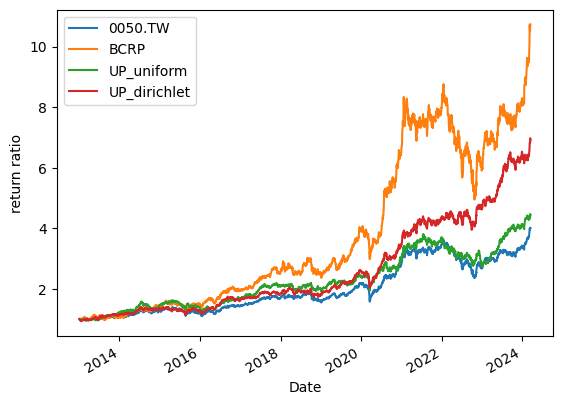

In [18]:
up_dirichlet = UP_dirichlet(r,period = 5)
up_dirichlet.run()
df['UP_dirichlet'] = np.cumprod(pay_fee_period(r,up_dirichlet.weight,up_dirichlet.period))
ax = df[benchmark_asset_name+['BCRP']+['UP_uniform','UP_dirichlet']].plot()
ax.set_ylabel("return ratio")

In [19]:
print(up_dirichlet.weight[-3:])
weight = up_dirichlet.weight[-1]
total_funds = 2000000
print('next rebalance amount(張數):',weight*total_funds/data[asset_name].values[-1]/1000)
print(df.columns)
print(data[asset_name].values[-1])
# print(r[-1],r[-2])

[[0.11130759 0.10377553 0.08233417 0.11634534 0.1106362  0.0879772
  0.09853882 0.09495081 0.09546346 0.09867089]
 [0.11130931 0.10356976 0.0825278  0.11682921 0.11024645 0.08777005
  0.09903066 0.0949394  0.0953621  0.09841526]
 [0.11151687 0.10356562 0.08230869 0.11697363 0.1101667  0.08721999
  0.09925738 0.09469644 0.09527338 0.0990213 ]]
next rebalance amount(張數): [4.47619817 0.6795018  1.3953581  0.30229632 0.93441981 1.48618049
 0.17643981 2.89736589 6.23372959 1.32695953]
Index(['0050.TW', '2303.TW', '2308.TW', '2317.TW', '2330.TW', '2382.TW',
       '2412.TW', '2454.TW', '2881.TW', '2891.TW', '3711.TW', 'BAH', 'UCRP',
       'BCRP', 'UP_uniform', 'UP_dirichlet'],
      dtype='object')
[  49.82660294  304.82809448  117.9750061   773.90045166  235.79701233
  117.37469482 1125.11315918   65.36726379   30.56705666  149.24539185]


# Exponentiated Gradient EG($\eta$)

- **Introduction**

    In the linear regression setting, Kivinen and Warmuth show that good performance can be achieved by choosing a weight vector ${\bf x}^{(t+1)}$ that is "close" to ${\bf x}^{(t)}$, We adapt their method and find a new weight vector ${\bf x}^{(t+1)}$ that (approximately) maximizes the following function:

    $$
    F({\bf x}^{(t+1)})=\eta \log({\bf x}^{(t+1)}\cdot{\bf r}^{(t)})-d({\bf x}^{(t+1)},{\bf x}^{(t)})
    $$

    where $\eta > 0$ is some parameter called the learning rate, and d is a distance measure that serves as a penalty term.

    - The learning rate $\eta$ controls the relative importance between the two terms.

    - The penalty term $-d({\bf x}^{(t+1)},{\bf x}^{(t)})$ tends to keep ${\bf x}^{(t+1)}$ close to ${\bf x}^{(t)}$.

    Here we use of the relative entropy as a distance function for motivating updates:

    $$
    {\bf D}_{RE}({\bf u}||{\bf v}) = \sum^{n}_{i=1} u_{i} \log\frac{u_{i}}{v_{i}} \quad \text{for } {\bf u}, {\bf v} \in {\mathbb R}^{n}
    $$

    Hence:

    $$
    d({\bf x}^{(t+1)},{\bf x}^{(t)})={\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})
    $$

    It is hard to maximize $F$ since both terms depend nonlinearly on ${\bf x}^{(t+1)}$, instead of finding the exact maximizer of $F$, we replace the first term with its first-order Taylor polynomial around ${\bf x}^{(t+1)}={\bf x}^{(t)}$.

    This approximation is reasonable if:

    - $F$ satisfies a Lipschitz condition

    - the weight vector ${\bf x}^{(t+1)}$ is relatively close to ${\bf x}^{(t)}$

    We also use a Lagrange multiplier to handle the constraint $\sum^{n}_{i=1}x^{(t+1)}_{i}=1$

    This leads us to maximize $\tilde{F}$ instead of $F$:

    $$
    \tilde{F}({\bf x}^{(t+1)},\gamma)=\eta(log({\bf x}^{(t)}\cdot{\bf r}^{(t)})+\frac{{\bf r}^{(t)}\cdot({\bf x}^{(t+1)}-{\bf x}^{(t)})}{{\bf x}^{(t)}\cdot{\bf r}^{(t)}})-{\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})+\gamma(\sum^{n}_{i=1}x^{t+1}_{i}-1)
    $$

    by setting the $n$ partial derivatives to zero (for $1\leq i\leq n$):

    $$
    \frac{\partial\hat{F}({\bf x}^{(t+1)},\gamma)}{\partial x^{(t+1)}_{i}}= \eta \frac{r^{(t)}_{i}}{{\bf x}^{(t)}\cdot {\bf r}^{(t)}}− \frac{\partial {\bf D}_{RE}({\bf x}^{(t+1)}||{\bf x}^{(t)})}{\partial x^{(t+1)}_{i}} + \gamma = 0
    $$

    and it implies:

    $$
    \eta\frac{r^{(t)}_{i}}{{\bf x}^{t}\cdot{\bf r}^{(t)} }−(\log\frac{x^{(t+1)}_{i}}{x^{(t)}_{i}}+1)+\gamma=0\quad \text{or} \quad x^{(t+1)}_{i}=x^{(t)}_{i}exp(\eta\frac{r^{(t)}_{i}}{{\bf x}^{(t)}\cdot {\bf r}^{(t)}}+\gamma-1)=0
    $$

    Enforcing the additional constraint $\sum^{n}_{i=1}x^{t+1}_{i}=1$ gives a portfolio update that we call the exponentiated gradient $EG(\eta)$ update:

    $$
    x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}
    $$
    
- **Remark**

    Intuitive concept about learning rate $\eta$:
    
    - If ${\bf x}^{(t)}$ is far from ${\bf x}^{*}$, then a small learning rate $\eta$ means that ${\bf x}^{(t+1)}$ will move slowly toward ${\bf x}^{*}$.

    - Conversely, if ${\bf x}^{(t)}$ is already close to ${\bf x}^{*}$, then a large learning rate may cause the algorithm to be misled by day-to-day fluctuations.(Overfitting)

    We can find that the learning rate $\eta \in [0.01,0.15]$ is a good choice.

- **Algorithm**
    
    The weight vector of day $t$ using EG strategy is the function given by:

    $$
    x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)} \quad \forall t \geq 2
    $$

    The initial weight vector is given by:

    $$
    {\bf x}^{(1)} = 
    \begin{pmatrix}
    \frac{1}{n} &
    \frac{1}{n} &
    \cdots &
    \frac{1}{n}
    \end{pmatrix}
    $$


      
# Analysis of EG($\eta$)

- **THEOREM I**

  Let ${\bf u} \in \Delta_{n}$ be a weight vector, $\{{\bf x}^{(i)}\}$ be the weight sequence updated by $EG(\eta)$, and ${\bf r}^{(t)}_{i} \geq c > 0 \quad \forall t,i$, and $\eta > 0$, then:

  $$
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\})\leq \frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}
  $$

  The above theorem says that the difference of the logrithmic return of $EG(\eta)$ and $CRP_{\bf u}$ is bounded by $\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}$.

  Hence, if we choose $\eta = 2c \sqrt{\frac{2\log(n)}{T}}$, then we have:

  $$
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\})\leq \frac{\sqrt{2T\log(n)}}{2c}
  $$

- **Proof:**

  **Settings:**

  Let

  $$
  Z_{t}=\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left( \frac{\eta r^{(t-1)}_{j}}{{\bf x}^{(t-1)}\cdot{\bf r}^{(t-1)}}\right)
  $$

  Then the $EG(\eta)$ strategy can be simplified as

  $$
  x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta r^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot {\bf r}^{(t-1)}}\right)}{Z_{t}} \quad \forall t \geq 2
  $$

  **Step 1:**

  Let

  $$
  \Delta_{t} = {\bf D}_{RE}({\bf u}||{\bf x}^{(t+1)}) - {\bf D}_{RE}({\bf u}||{\bf x}^{(t)}) = -\sum^{n}_{i=1} u_{i} \log\left(\frac{x^{(t+1)}_{i}}{x^{(t)}_{i}}\right) = -\sum^{n}_{i=1} u_{i}\left(\frac{\eta x^{(t)}_{i}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} - \log(Z_{t})\right) = -\eta \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} + \log(Z_{t})
  $$

  **Step 2:**

  We want to bound the number $\log(Z_{t})$, we apply the following $2$ facts:

  - $Fact$ $1$:

      For all $\alpha \in [0,1]$ and $x \in \mathbb{R}$

      $$
      \log(1 - \alpha (1 - e^{x})) \leq \alpha x + \frac{x^{2}}{8}
      $$

      $proof$:

      Let 
      
      $$
      f(x)=\alpha x + \frac{x^{2}}{8} - \log(1 - \alpha (1 - e^{x}))
      $$
      
      We wish to show that $f(x) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(x)&=\alpha + \frac{x}{4} - \frac{\alpha e^{x}}{1-\alpha +\alpha e^x}
      \\
      f''(x)&=\frac{1}{4} - \frac{\alpha e^{x}}{1-\alpha +\alpha e^x} + (\frac{\alpha e^{x}}{1-\alpha +\alpha e^x})^{2}
      \end{align*}
      $$

      Clearly $f''(x)$ is non-negative for all $x$, and $f(0)=f'(0)=0$, thus $f$ is minimized when $x=0$, hence $f(x) \geq 0 \quad \Box$
  
  - $Fact$ $2$:

      For all $\beta > 0$ and $x \in [0,1]$

      $$
      \beta^{x} \leq 1 - (1 - \beta) x
      $$

      $proof$:

      Let

      $$
      f(\beta)=1-(1-\beta)x-\beta^{x}
      $$

      We wish to show that $f(\beta) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(\beta)&=x-x{\beta}^{x-1}
      \\
      f''(\beta)&=-x(x-1){\beta}^{x-2}
      \end{align*}
      $$

      Since $x \in [0,1]$, $f''(\beta)$ is non-negative for all $\beta>0$, and $f(1)=f'(1)=0$, thus $f$ is minimized when $\beta=1$, hence $f(\beta) \geq 0 \quad \Box$

      
  Since $x^{(t)}_{i} \in [0,1] \quad \forall t,i \quad$, from $Fact$ $1$, $Fact$ $2$, we have:

  $$
  \begin{align*}
  {\bf Z_{t}}&=\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta r^{(t-1)}_{j}}{{\bf x}_{(t-1)} \cdot {\bf r}_{(t-1)}}\right)
  \\
  &\leq \sum^{n}_{j=1} x^{(t)}_{j}\left(1 - (1 - \exp\left(\frac{\eta}{{\bf x}_{(t)} \cdot {\bf r}_{(t)}}\right))r^{(t-1)}_{j}\right) = 1 - (1 - \exp\left(\frac{\eta}{{\bf x}_{(t)} \cdot {\bf r}_{(t)}}\right)){\bf x}_{(t)} \cdot {\bf r}_{(t)}
  \\
  log({\bf Z_{t}}) &\leq \eta + \frac{\eta^{2}}{8({\bf x}_{(t)} \cdot {\bf r}_{(t)})^{2}}
  \end{align*}
  $$

  **Step 3:**

  - $Fact$ $3$:

      For all $x \in \mathbb{R}$

      $$
      1 - e^{x} \leq -x
      $$

      $proof$:

      Let 
      
      $$
      f(x)=-x-1+e^{x}
      $$
      
      We wish to show that $f(x) \geq 0$, we have that:

      $$
      \begin{align*}
      f'(x)&=-1+e^{x}
      \\
      f''(x)&=e^{x}
      \end{align*}
      $$

      Clearly $f''(x)$ is non-negative for all $x$, and $f(0)=f'(0)=0$, thus $f$ is minimized when $x=0$, hence $f(x) \geq 0 \quad \Box$

  Combining Step $1$ and Step $2$, we have:

  $$
  \begin{align*}
  \Delta_{t} &= -\eta \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}} + \log(Z_{t}) \leq \eta\left(1 - \frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \\
  &\leq -\eta \log\left(\frac{{\bf u} \cdot {\bf r}^{(t)}}{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}=\eta \log\left(\frac{{\bf x}^{(t)} \cdot {\bf r}^{(t)}}{{\bf u} \cdot {\bf r}^{(t)}}\right) + \frac{\eta^{2}}{8({\bf x}^{(t)} \cdot {\bf r}^{(t)})^{2}}
  \end{align*}
  $$

  **Step 4:**

  Summing over all $T$ and since $x^{(t)}_{i} \geq c \quad \forall t,i$, we have:

  $$
  \begin{align*}
  -{\bf D}_{RE}({\bf u}||{\bf x}^{(1)}) &\leq {\bf D}_{RE}({\bf u}||{\bf x}^{(T+1)}) - {\bf D}_{RE}({\bf u}||{\bf x}^{(1)}) 
  \\
  &= \Delta_{T}+\Delta_{T-1}+\cdots+\Delta_{1}
  \\
  &\leq \eta \sum^{T}_{k=1} \log\left(\frac{{\bf x}^{(k)} \cdot {\bf r}^{(k)}}{{\bf u} \cdot {\bf r}^{(k)}}\right) + \frac{\eta^{2}T}{8c^{2}}
  \\
  &=\eta \sum^{T}_{k=1} (\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\log({\bf u} \cdot {\bf r}^{(k)})) + \frac{\eta^{2}T}{8c^{2}}
  \end{align*}
  $$

  Sorting the inequality above, we obtain:

  $$
  \begin{align*}
  -{\bf D}_{RE}({\bf u}||{\bf x}^{(1)}) &\leq \eta \sum^{T}_{k=1}(\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\log({\bf u} \cdot {\bf r}^{(k)})) + \frac{\eta^{2}T}{8c^{2}}
  \\
  \sum^{T}_{k=1}\log({\bf x}^{(k)} \cdot {\bf r}^{(k)})-\sum^{T}_{k=1}\log({\bf u} \cdot {\bf r}^{(k)})&\leq \frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}}
  \\
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf x}^{(i)}\})&\leq \frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8c^{2}} \quad \Box
  \end{align*}
  $$

# Problem with EG($\eta$)

For an appropriate choice of $\eta$, when the number of days $T$ becomes large, the difference between the logrithmic return achieved by $EG(\eta)$ is guaranteed to converge to the logarithmic wealth of the $BCRP$. However, This Theorem is not strong enough to show that $EG(\eta)$ is $UP$. This is because choosing the proper $\eta$ requires knowledge of both the number of trading days and the ratio $c$ in advance. We will deal with both of these difficulties.

In [20]:
def eg_eta(r):#this function compute eta such that ratio of log return is bounded by ((2t*log(n))^(1/2))/(2c)
    #r is the price relative matrix
    k=1
    for i in range(r.shape[0]):
        if k>min(r[i]):
            k=min(r[i])
    return 2*k*(2*(np.log(r.shape[1]))/r.shape[0])**(1/2)

class EG():
  def __init__(self, r, eta=eg_eta(r), period=1):
    '''r = 'return' (n*n matrix)'''
    self.t = 0
    self.eta = eta
    self.n = r.shape[1]
    self.period = period
    self.weight = np.zeros(((r.shape[0])//self.period,self.n))
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp

  def step(self, x, last_b):
    b = last_b * np.exp(self.eta * x / sum(x * last_b))
    return b / sum(b)

  def run(self):
    if self.r.shape[0]==0:
      return np.ones(self.n)/self.n
    self.weight[0] = np.ones(self.n)/self.n
    for t in range(1,self.r.shape[0]):
      self.weight[t] = self.step(self.r[t],self.weight[t-1])
    return

The choice of eta in THEROEM I: 0.07349043074665548


Text(0, 0.5, 'return ratio')

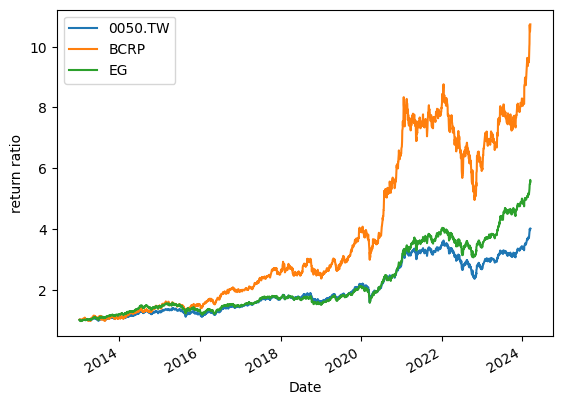

In [21]:
eg = EG(r[:])
print(f"The choice of eta in THEROEM I: {eg_eta(r)}")
eg.run()
df['EG'] = np.cumprod(pay_fee_period(r,eg.weight,eg.period))
ax = df[benchmark_asset_name+['BCRP']+['EG']].plot()
ax.set_ylabel("return ratio")

# Modified Exponentiated Gradient $\tilde{EG}(\alpha ,\eta)$

We first deal with the dependence of $\eta$ on $c$

When no lower bound $c$ on $x^{(t)}_{i}$ is known, we can use the following portfolio update algorithm, which is parameterized by a real number $\alpha \in$ [0, 1].

Let

$$
\tilde{\bf r}^{(t)}=(1-\frac{\alpha}{n}){\bf r}^{(t)}+(\frac{\alpha}{n}){\bf 1}
$$

where ${\bf 1}$ is an all 1's vector.

As before, we maintain a portfolio vector ${\bf x}^{(t)}$ that is updated using $\tilde{\bf r}^{(t)}$ rather than ${\bf r}^{(t)}$:

$$
x^{(t)}_{i} = \frac{x^{(t-1)}_{i} \exp\left(\frac{\eta \tilde{r}^{(t-1)}_{i}}{{\bf x}^{(t-1)} \cdot \tilde{{\bf r}}^{(t-1)}}\right)}{\sum^{n}_{j=1} x^{(t-1)}_{j} \exp\left(\frac{\eta \tilde{r}^{(t-1)}_{j}}{{\bf x}^{(t-1)} \cdot \tilde{{\bf r}}^{(t-1)}}\right)} \quad \forall t \geq 2
$$

The initial portfolio vector is given by:

$$
{\bf x}^{(1)} = 
\begin{pmatrix}
\frac{1}{n} &
\frac{1}{n} &
\cdots &
\frac{1}{n}
\end{pmatrix}
$$

Further, the portfolio vector that we invest with is also slightly modified. Specifically, the algorithm uses the portfolio vector:

$$
\tilde{\bf x}^{(t)}=(1-\alpha){\bf x}^{(t)}+(\frac{\alpha}{n}){\bf 1}
$$

and so the logrithmic return achieved is $\sum^{t}_{i=1} \log({\bf r}^{(i)} \cdot \tilde{{\bf x}}^{(i)})$

We call this modified algorithm $\tilde{EG}(\alpha ,\eta)$


# Analysis of $\tilde{EG}(\alpha ,\eta)$

- **THEOREM II**

  Let ${\bf u} \in \Delta_{n}$ be a weight vector, $\{{\bf \tilde{x}}^{(i)}\}$ be the weight sequence updated by $\tilde{EG}(\alpha ,\eta)$, and $\underset{i}{max}\{r^{(t)}_{i}\}=1$ $\forall t$, and for $\alpha \in (1,\frac{1}{2}]$ and $\eta > 0$, then:

  $$
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\}) \leq 2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$

  The above theorem says that the difference of the logrithmic return of $\tilde{EG}(\alpha,\eta)$ and $CRP_{\bf u}$ is bounded by $2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}$.

  Furthermore, if $T \geq 2n^{2}\log(n)$, and we set $\alpha=(n^{2}\log(\frac{n}{8T}))^{\frac{1}{4}}$, $\eta=\sqrt{8\alpha^{2}\log(\frac{n}{n^{2}T})}$, then we have:

  $$
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\}) \leq 2(2n^{2}\log(n))^{\frac{1}{4}}T^{\frac{3}{4}}
  $$

- **Remark**

  W.L.O.G. we may assume $\underset{i}{max}\{r^{(t)}_{i}\}=1$ $\forall t$, since multiplying the price relatives ${\bf r}^{(t)}$ by a constant $k$ simply adds $\log(k)$ to the logrithmic return, leaving the difference between the logrithmic return achieved by the $\tilde{EG}(\eta)$ update and $BCRP$ is unchanged.

- **Proof:**

  First, we need the following fact:

  - $Fact$ $4$:

    For $\alpha \in (0,\frac{1}{2}]$

    $$
    \log(1-\alpha)\geq-2\alpha
    $$

    $Proof$:

    Let

    $$
    f(\alpha)=\log(1-\alpha)+2\alpha
    $$

    then we have:

    $$
    f'(\alpha)=\frac{-1}{1-\alpha}+2\geq 0
    $$

    and $f(\frac{1}{2})=\log(\frac{1}{2})+1>0$, $f'(\frac{1}{2})=0$, Hence, $f$ is minimized when $\alpha=\frac{1}{2} \quad \Box$

  **Step 1:**
  
    From our assumption that $\underset{i}{max}\{r^{(t)}_{i}\}=1$ $\forall t$, we have:

    $$
    \frac{\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)}}{{\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)}}=\frac{(1-\alpha){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n}){\bf 1}\cdot{\bf r}^{(t)}}{{(1-\frac{\alpha}{n}){\bf x}^{(t)}\cdot{\bf r}^{(t)}}+(\frac{\alpha}{n}){\bf 1}\cdot{\bf x}^{(t)}}\geq\frac{(1-\alpha){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n})}{(1-\frac{\alpha}{n}){\bf x}^{(t)}\cdot{\bf r}^{(t)}+(\frac{\alpha}{n})}
    $$

    If we view the right-hand side of the inequality as a function of $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}$:
    
    $$
    \begin{align*}
    f(k)&=\frac{(1-\alpha)k+(\frac{\alpha}{n})}{(1-\frac{\alpha}{n})k+(\frac{\alpha}{n})}
    \\
    f'(k)&=\frac{\alpha(\frac{1}{n}-1)}{((1-\frac{\alpha}{n})k+(\frac{\alpha}{n}))^{2}}\leq 0 
    \end{align*}
    $$

    We see that it is a decreasing function of $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}$, and so it is minimized when $k={\bf x}^{(t)}\cdot{\bf r}^{(t)}=1$, thus we have:

    $$
    \begin{align*}
    \frac{\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)}}{{\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)}}&\geq(1-\alpha)+\frac{\alpha}{n}
    \\
    &\text{equivalently}
    \\
    \log(\tilde{\bf x}^{(t)}\cdot{\bf r}^{(t)})&\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})+\log((1-\alpha)+\frac{\alpha}{n})
    \\
    &\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})+\log(1-\alpha) 
    \\
    &\geq \log({\bf x}^{(t)}\cdot\tilde{\bf r}^{(t)})-2\alpha \quad -(1)
    \end{align*}
    $$

  **Step 2:**

    Apply Theorem I to the modified price relative $\{\tilde{\bf r}^{(i)}\}$:

    $$
    \log{W}(\{\tilde{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{\tilde{\bf r}^{(i)}\},\{{\bf {x}}^{(i)}\})=\sum^{t}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{t}_{i=1}\log({\bf {x}}^{(i)}\cdot\tilde{\bf r}^{(i)})\leq\frac{{\bf D}_{RE}({\bf u} || {\bf x}_{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
    $$
    
    Here we use the fact that $\tilde {r}^{(t)}_{i}\geq\frac{\alpha}{n}$

    since (also follows from our assumption $\underset{i}{max}\{r^{(t)}_{i}\}=1$ $\forall t$)

    $$
    {\bf u}\cdot\tilde{\bf r}^{(t)}=(1-\frac{\alpha}{n}){\bf u}\cdot{\bf r}^{(t)}+\frac{\alpha}{n}\geq{\bf u}\cdot{\bf r}^{(t)}
    $$

    We have:

    $$
    \sum^{t}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})\geq\sum^{t}_{i=1}\log({\bf u}\cdot{\bf r}^{(i)}) \quad -(2)
    $$
  
  **Step 3:**

  Summing over all $T$ in $(1)$, 

  $$
  \sum^{T}_{i=1}\log({\bf x}^{(i)}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})\leq 2\alpha T
  $$

  Combine with $(2)$,

  $$
  \begin{align*}
  \sum^{T}_{i=1}\log({\bf u}\cdot{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})&\leq\sum^{T}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})
  \\
  &\leq\sum^{T}_{i=1}\log({\bf u}\cdot\tilde{\bf r}^{(i)})-\sum^{T}_{i=1}\log({\bf x}^{(i)}\cdot\tilde{\bf r}^{(i)})+2\alpha T
  \\
  &\leq 2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta}+\frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  \end{align*}
  $$

  which is,

  $$
  log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\leq 2\alpha T+\frac{{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}{\eta} + \frac{\eta T}{8(\frac{\alpha}{n})^{2}}
  $$

  We complete the first part of Theorem II. $\quad \Box$

**Step 4:**

  The second part of Theorem II needs the following fact:

  - $Fact$ $5$:

    $$
    {{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}\leq \log(n) 
    $$

    when ${\bf x}^{(1)}$ is a uniform probability vector.

    Proof:

    $$
    {{\bf D}_{RE}({\bf u} || {\bf x}^{(1)})}=\sum^{n}_{i=1}u_{i}\log\left(\frac{u_{i}}{\frac{1}{n}}\right)=\sum^{n}_{i=1}u_{i}\log(nu_{i})\leq\sum^{n}_{i=1}u_{i}\log(n)\leq \log(n)\sum^{n}_{i=1}u_{i}=\log(n)
    $$

  With $Fact$ $5$ and the choices of $\alpha$ and $\eta$, the second part directly follows from the first part. $\quad \Box$



In [22]:
class MEG():
  def __init__(self, r, period=1, alpha=((r.shape[1]**2)*np.log(r.shape[1])/(8*r.shape[0]))**(1/4), eta=((8*((((r.shape[1]**2)*np.log(r.shape[1])/(8*r.shape[0]))**(1/4))**2)*np.log(r.shape[1]))/((r.shape[1]**2)*r.shape[0]))**(1/2)):
    '''r = 'return' (n*n matrix)'''
    self.t = 0
    self.eta = eta
    self.alpha = alpha
    self.n = r.shape[1]
    self.period = period
    self.weight = np.zeros(((r.shape[0])//self.period,self.n))
    # price relative of rebalence in period days
    self.r = np.zeros(((r.shape[0])//self.period,self.n))
    for i in range((r.shape[0])//self.period):
      temp = np.ones(self.n)
      for j in range(self.period):
        temp*=r[i*self.period + j]
      self.r[i] = temp
    # calculate the modified price relative
    self.r = self.r*(1-self.alpha/self.n)+np.ones(self.r.shape)*(self.alpha/self.n)

  def step(self, x, last_b):
    b = last_b * np.exp(self.eta * x / sum(x * last_b))
    return b / sum(b)

  def run(self):
    if self.r.shape[0]==0:
      return np.ones(self.n)/self.n
    self.weight[0] = np.ones(self.n)/self.n
    for t in range(1,self.r.shape[0]):
      self.weight[t] = self.step(self.r[t],self.weight[t-1])
    self.weight = self.weight*(1-self.alpha)+np.ones(self.weight.shape)*(self.alpha/self.n)
    return

Text(0, 0.5, 'return ratio')

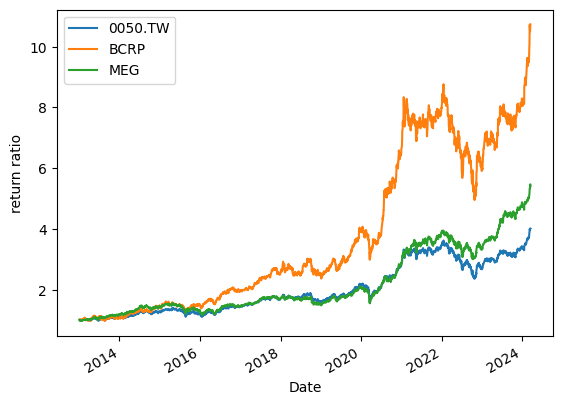

In [23]:
meg = MEG(r[:])
meg.run()
df['MEG'] = np.cumprod(pay_fee_period(r,meg.weight,meg.period))
ax = df[benchmark_asset_name+['BCRP']+['MEG']].plot()
ax.set_ylabel("return ratio")

# Staged $\tilde{EG}(\alpha ,\eta)$

After dealing with the dependence of $\eta$ on $c$, we still have the issue that the learning rate $\eta$ must be chosen in advance as a function of $T$. The following algorithm and corollary show how a doubling trick can be used to obtain a universal portfolio algorithm.

- **Staged $\tilde{EG}(\alpha ,\eta)$**

  - The Staged $\tilde{EG}(\alpha ,\eta)$ update runs in stages.
  - The number of days in the stage 0 is $2n^{2}\log(n)$, and the number of days in stage $i>0$ is $2^{i}n^{2}\log(n)$.
  - At the start of each stage, the weight vector is reinitialized to the equally weighted vector and $\alpha$ and $\eta$ are set as in Theorem II using the number of days in the stage as the value for $T$.
  - Hence, if $T>2n^{2}\log(n)$ is the total number of days, the last stage entered is numbered $\lceil \log_{2}(\frac{T}{2n^{2}\log(n)}) \rceil$.

    $
    \begin{array}{c|cccccc}
    \text{stages} & 0 & 1 & 2 & 3 & \cdots & k \\
    \hline
    \text{number of days} & 2n^{2}\log(n) & 2n^{2}\log(n) & 2^{2}n^{2}\log(n) & 2^{3}n^{2}\log(n) & \cdots & 2^{k}n^{2}\log(n)
    \end{array}
    $

- **Corollary**

  The Staged $\tilde{EG}(\alpha ,\eta)$ update is a $UP$ algorithm.

- **Proof:**

  Apply Staged $\tilde{EG}(\alpha ,\eta)$ for any ${\bf u} \in \Delta_{n}$, for any price relative sequence $\{{\bf r}^{(i)}\}$, and let $b=\lceil \log_{2}(\frac{T}{2n^{2}\log(n)}) \rceil$, then by Theorem II we have:

  $$
  \begin{align*}
  \log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})&=\sum^{T}_{i=1}\log({\bf u}\cdot{\bf r}^{(i)})-\sum^{T}_{i=1}\log(\tilde{\bf x}^{(i)}\cdot{\bf r}^{(i)})
  \\
  &\leq 4n^{2}\log(n)+\sum^{b}_{i=1}2(2n^{2}\log(n))^{\frac{1}{4}}(2^{i}n^{2}\log(n))^{\frac{1}{4}}
  \\
  &=4n^{2}\log(n)+\sum^{b}_{i=1}2(2)^{\frac{1}{4}}(2^{i})^{\frac{1}{4}}2(2n^{2}\log(n))
  \\
  &\leq 2^{\frac{5}{4}}n^{2}\log(n)(1+\sum^{b}_{i=1}(2^{\frac{3}{4}})^{i})
  \\
  &=2^{\frac{5}{4}}n^{2}\log(n)(1+\frac{(2^{\frac{3}{4}})^{b+1}-1}{2^{\frac{3}{4}}-1})
  \\
  &\leq 6n^{2}\log(n)(1+(2^{\frac{3}{4}})^{b})
  \\
  &\leq 6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})
  \end{align*}
  $$

  Since the above inequality holds for any price relative sequence $\{{\bf r}^{(i)}\}$, Hence we have:

  $$
  \underset{\{{\bf r}^{(i)}\}}{max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\} \leq 6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})
  $$

  Now let ${\bf u}$ be the weight vector choosen by $BCRP$ ${\bf x^{*}}$, and divides the above inequality by $T$, then we obtain:

  $$
  \frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\} \leq \frac{6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})}{T}
  $$

  Letting $T \to \infty$:

  $$
  \lim_{T \to \infty}\frac{1}{T}\underset{\{{\bf r}^{(i)}\}}{max}\{\log{W}(\{{\bf r}^{(i)}\},\{{\bf u}\})-\log{W}(\{{\bf r}^{(i)}\},\{{\bf \tilde{x}}^{(i)}\})\} \leq \lim_{T \to \infty}\frac{6n^{2}\log(n)(1+(\frac{T}{2n^{2}\log(n)})^{\frac{3}{4}})}{T}=0
  $$

In [24]:
class SMEG():
    def __init__(self, r, period = 1):
    #----------------------------------------------------------------
        #r is the price relative matrix
        #stage is the number of days in each stage
        #stageday is the day which is rebalnced equally weighted
        #alpha is the modify parameter
        #eta is the learning rate
        
        self.r=r
        self.n = r.shape[1]
        self.period = period
        self.stage=self.stage_cal()
        self.stageday=self.stageday_cal()
        self.alpha=self.alpha_cal()
        self.eta=self.eta_cal()
        # calculate the modified price relative
        self.mr = self.modify_price_relative()
        #----------------------------------------------------------------
        #self.x is the portfolio choosen by MEG
        self.weight = self.smeg_portfolio_cal()
    
    def stage_cal(self):#calculate the number of days in each stage
        stage=[]
        k=self.r.shape[0]//((2*(self.n**2)*np.log(self.n))//1)
        for i in range(int(self.r.shape[0]//((2*(self.n**2)*np.log(self.n))//1))):
            if k>=(2**i):
                if i==0:
                    stage.append(((2*(self.n**2)*np.log(self.n))//1))
                    k-=1
                elif i>0:
                    stage.append((((2**i)*(self.n**2)*np.log(self.n))//1))
                    k-=i
            elif k<(2**i):
                    a=sum(stage)
                    stage.append(self.r.shape[0]-a)
                    break
        return stage
    
    
    def stageday_cal(self):#calculate the day which is rebalnced equally weighted
        stageday=[]
        s=0
        for i in range(len(self.stage)):
            s+=self.stage[i]
            stageday.append(s)
        return  stageday
    
    def alpha_cal(self):#calculate alpha in each stage
        alpha=[]
        for i in range(len(self.stage)):
            if i!=len(self.stage)-1:
                alpha.append(((self.n**2)*np.log(self.n)/(8*(self.stage[i])))**(1/4))
            elif i==len(self.stage)-1:
                alpha.append(((self.n**2)*np.log(self.n)/(8*((((2**i)*(self.n**2)*np.log(self.n))//1))))**(1/4))
        return alpha

    def eta_cal(self):#calculate eta in each stage
        eta=[]
        for i in range(len(self.stage)):
            if i!=len(self.stage)-1:
                eta.append(((8*(self.alpha[i]**2)*np.log(self.n))/((self.n**2)*self.stage[i]))**(1/2))
            elif i==len(self.stage)-1:
                eta.append(((8*(self.alpha[i]**2)*np.log(self.n))/((self.n**2)*(((2**i)*(self.n**2)*np.log(self.n))//1)))**(1/2))
        return eta
    
    def modify_price_relative(self):#modify the price relative matrix
        x1=np.ones(self.n)
        mr=[]
        for i in range(self.r.shape[0]):
            
            #k is the index of stage where i is
            if i< self.stageday[0]:
                k=0
            else:
                for j in range(len(self.stageday)):
                    if self.stageday[j] <= i and i < self.stageday[j-1]:
                        k=j
            
            mr.append((1-self.alpha[k]/self.n)*self.r[i]+(self.alpha[k]/self.n)*x1)
        return  mr
    
    def smeg_portfolio_cal(self):
        
        x=[]   #EG portfolio matrix
        smx=[]  #SMEG portfolio matrix 
        x1=np.ones(self.n)
        x2=[]
        for i in range(self.n):
            x2.append(1/self.n)
        x.append(x2)
        
        for t in range(1,self.r.shape[0]):
        #fix day t (index t means day t+1)
        
            #k is the index of stage where t is
            if t< self.stageday[0]:
                k=0
            else:
                for i in range(len(self.stageday)):
                    if self.stageday[i] <= t and t < self.stageday[i-1]:
                        k=i
                    
            if t in self.stageday:
                x.append(x2)
            else:
                xx=[]
                for i in range(self.n):
                    #i-th component of day t
                    
                    #x=p/q
                    p=x[t-1][i]*np.exp( (self.eta[k] * self.mr[t-1][i]) / (np.inner(x[t-1],self.mr[t-1])) )
                    q=0
                    for j in range(self.n):
                        q=q+x[t-1][j]*np.exp( (self.eta[k] * self.mr[t-1][j]) / (np.inner(x[t-1],self.mr[t-1])) )
                    x_temp=p/q
                    xx.append(x_temp)
                x.append(xx)
        
        #modify the portfolio matrix
        for i in range(self.r.shape[0]):
            
            #k is the index of stage where t is
            if i< self.stageday[0]:
                k=0
            else:
                for j in range(len(self.stageday)):
                    if self.stageday[j] <= i and i < self.stageday[j-1]:
                        k=j
            
            if i in self.stageday or i==0:
                smx.append(x2)
            else:
                smx.append((1-self.alpha[k])*np.array(x[i])+(self.alpha[k]/self.n)*x1)
        return np.array(smx)
    
smeg=SMEG(r)
print(smeg.stage)
print(smeg.eta)
print(meg.eta)


[460.0, 460.0, 1813.0]
[0.01000842846730487, 0.01000842846730487, 0.005946200384014406]
0.0026299926786301714


Text(0, 0.5, 'return ratio')

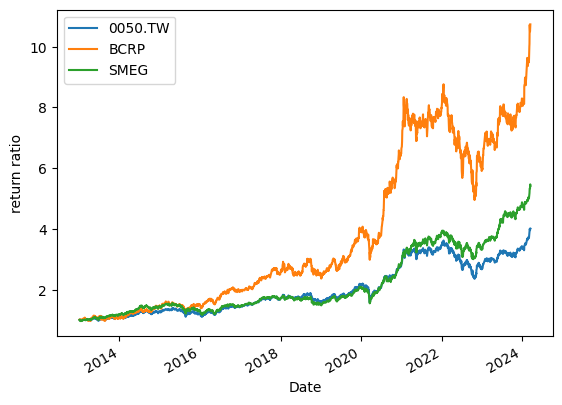

In [25]:
smeg=SMEG(r)
df['SMEG'] = np.cumprod(pay_fee_period(r,smeg.weight,smeg.period))
ax = df[benchmark_asset_name+['BCRP']+['SMEG']].plot()
ax.set_ylabel("return ratio")

Text(0, 0.5, 'return ratio')

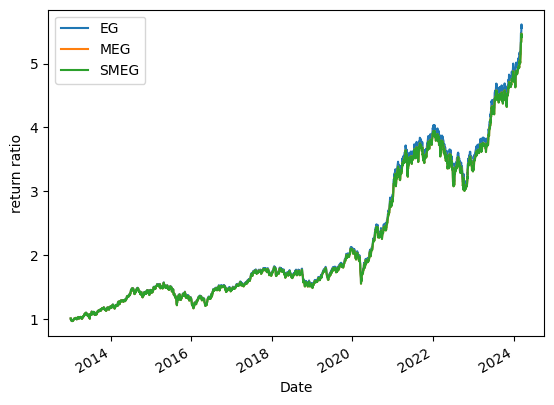

In [26]:
ax = df[['EG','MEG','SMEG']].plot()
ax.set_ylabel("return ratio")

# Compare the Wealth of All Portfolio Selection

Text(0, 0.5, 'return ratio')

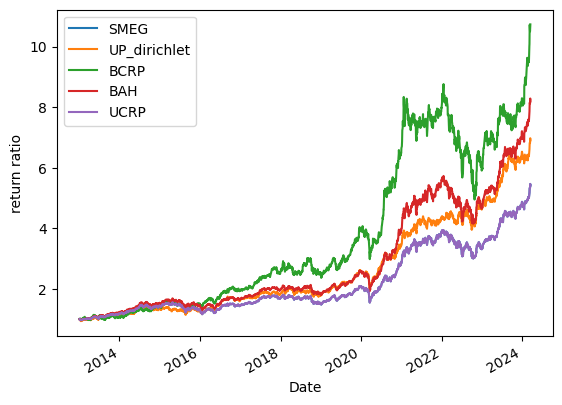

In [28]:
ax = df[['SMEG','UP_dirichlet','BCRP','BAH','UCRP']].plot()
ax.set_ylabel("return ratio")

# Backtesting Portfolios

In [29]:
%matplotlib inline
import quantstats as qs
def show_performance(Alg,benchmark = None):
  """input: Alg -> class of the algorithm
            benchmark -> array of return ratio"""
  df['Alg'] = pay_fee_period(r,Alg.weight,Alg.period)-1
  df['benchmark'] = benchmark
  stock = df['Alg']
  qs.reports.metrics(stock,benchmark=df['benchmark'],mode='full')
  qs.reports.plots(stock,benchmark=df['benchmark'],mode='full',benchmark_title = 'S&P500')
  #,strategy_title = Alg.name
  return

In [30]:
print(data[benchmark_asset_name])
print(data[benchmark_asset_name].pct_change().dropna())

               0050.TW
Date                  
2013-01-02   38.443092
2013-01-03   38.761101
2013-01-04   38.513767
2013-01-07   38.337097
2013-01-08   38.089760
...                ...
2024-03-08  153.664795
2024-03-11  152.122665
2024-03-12  153.714539
2024-03-13  154.460724
2024-03-14  154.311493

[2734 rows x 1 columns]
             0050.TW
Date                
2013-01-03  0.008272
2013-01-04 -0.006381
2013-01-07 -0.004587
2013-01-08 -0.006452
2013-01-09  0.003710
...              ...
2024-03-08  0.014117
2024-03-11 -0.010036
2024-03-12  0.010464
2024-03-13  0.004854
2024-03-14 -0.000966

[2733 rows x 1 columns]


# Performance of BCRP


c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2013-01-03   2013-01-03
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          301.4%       972.96%
CAGR﹪                     8.94%        15.75%

Sharpe                     0.87         1.04
Prob. Sharpe Ratio         99.79%       99.97%
Smart Sharpe               0.86         1.02
Sortino                    1.28         1.59
Smart Sortino              1.26         1.57
Sortino/√2                 0.9          1.12
Smart Sortino/√2           0.89         1.11
Omega                      1.19         1.19

Max Drawdown               -34.86%      -43.48%
Longest DD Days            749          737
Volatility (ann.)          16.24%       23.79%
R^2                        0.77         0.77
Information Ratio          0.05         0.05
Calmar            

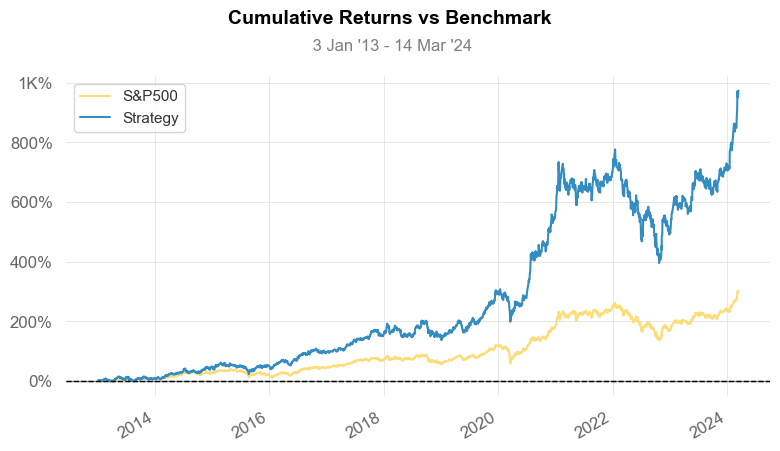

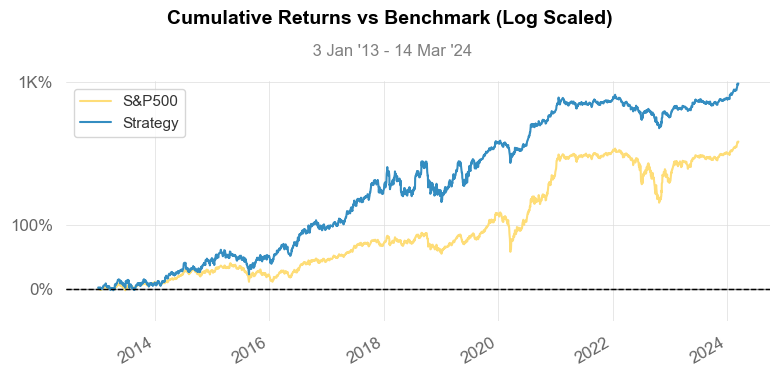

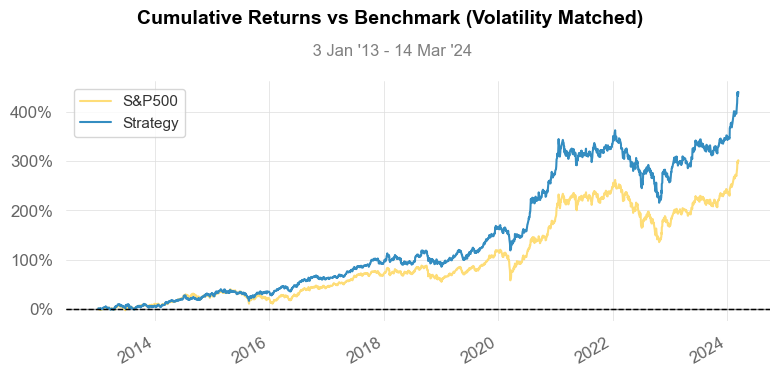

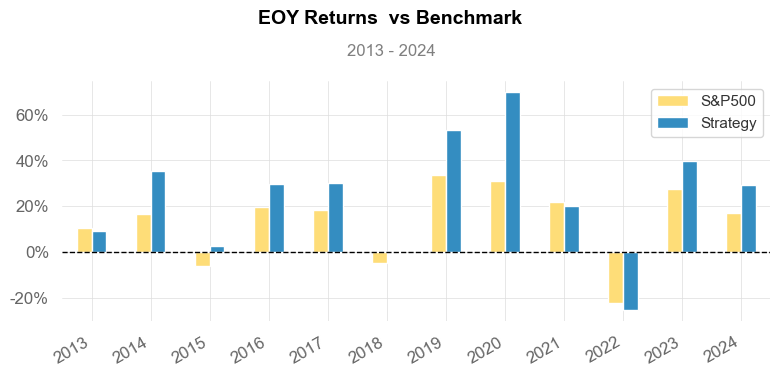

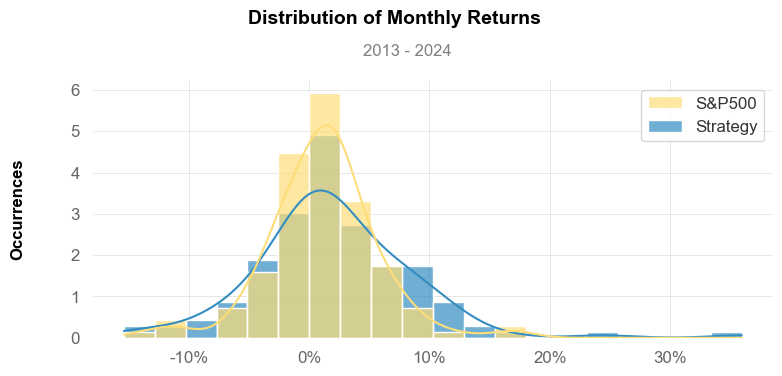

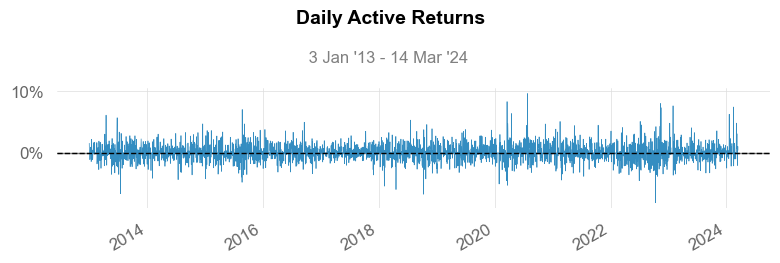

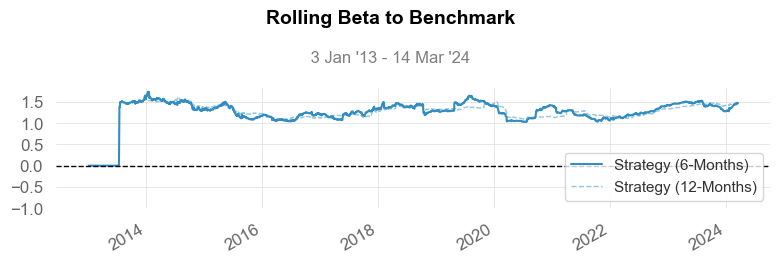

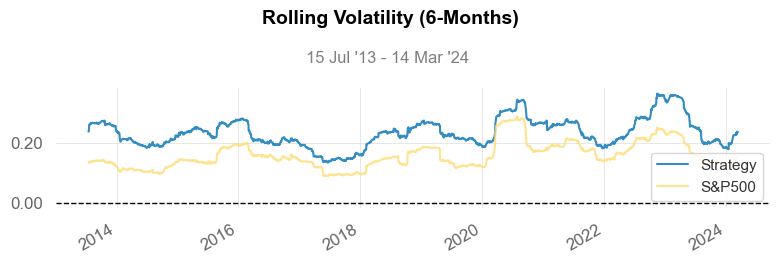

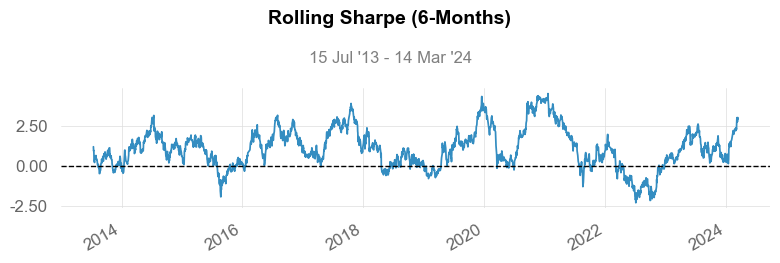

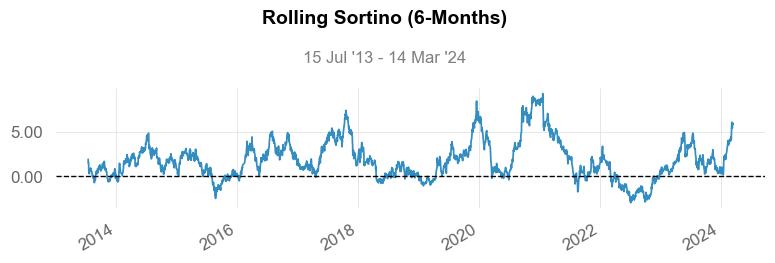

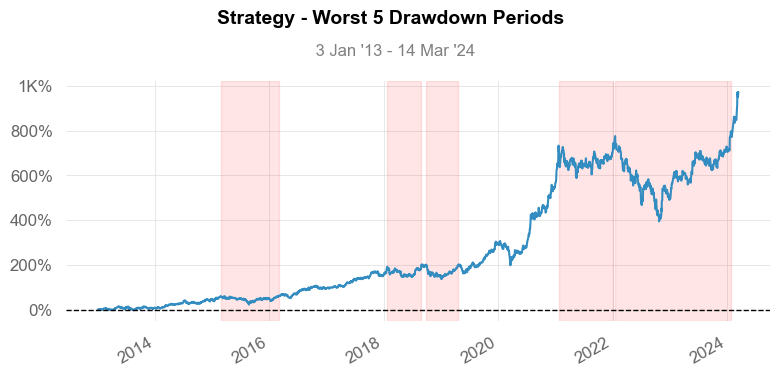

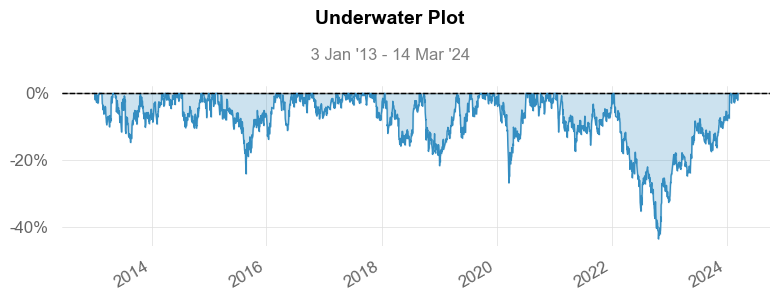

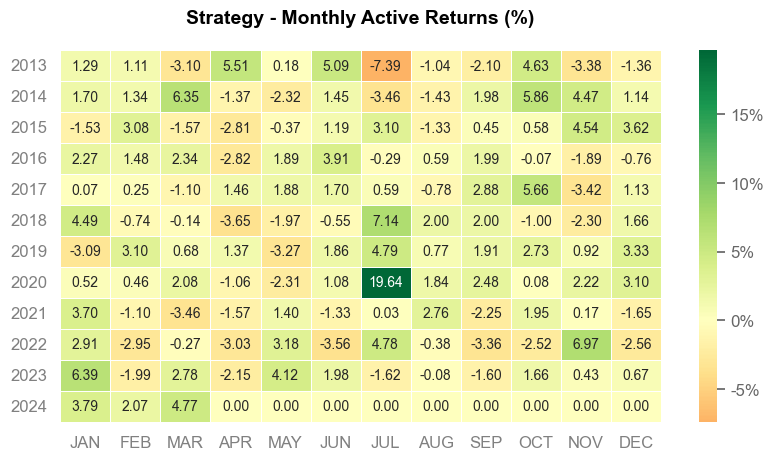

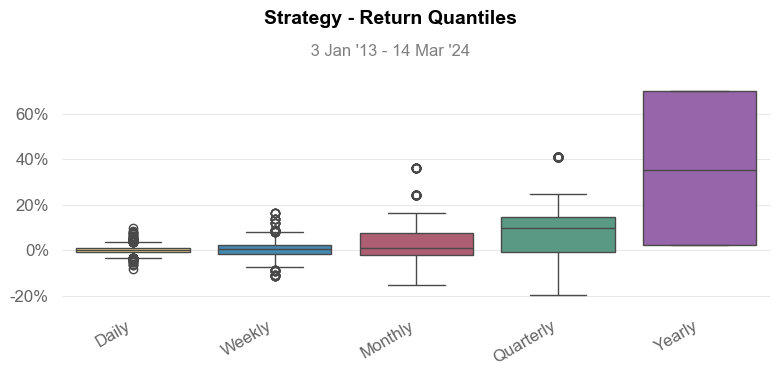

In [31]:
show_performance(bcrp,benchmark = data[benchmark_asset_name].pct_change().dropna())


# Performance of BAH


c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2013-01-03   2013-01-03
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          301.4%       635.45%
CAGR﹪                     8.94%        13.09%

Sharpe                     0.87         1.16
Prob. Sharpe Ratio         99.79%       99.99%
Smart Sharpe               0.86         1.15
Sortino                    1.28         1.72
Smart Sortino              1.26         1.7
Sortino/√2                 0.9          1.22
Smart Sortino/√2           0.89         1.2
Omega                      1.22         1.22

Max Drawdown               -34.86%      -28.03%
Longest DD Days            749          505
Volatility (ann.)          16.24%       17.15%
R^2                        0.83         0.83
Information Ratio          0.05         0.05
Calmar              

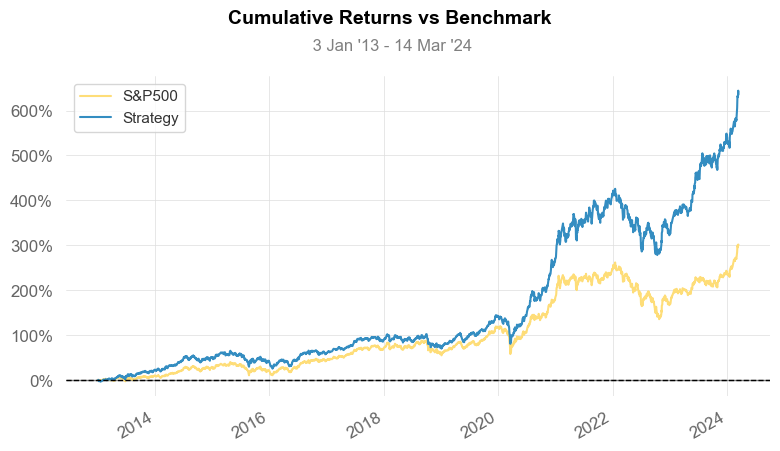

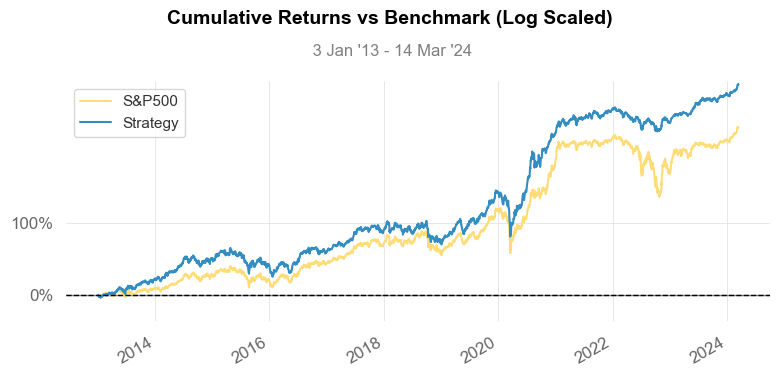

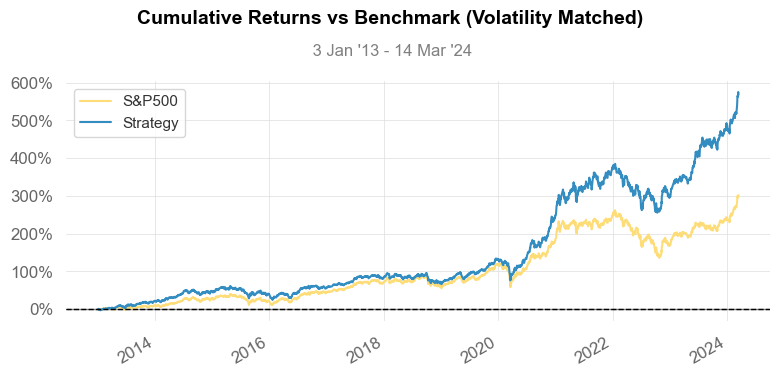

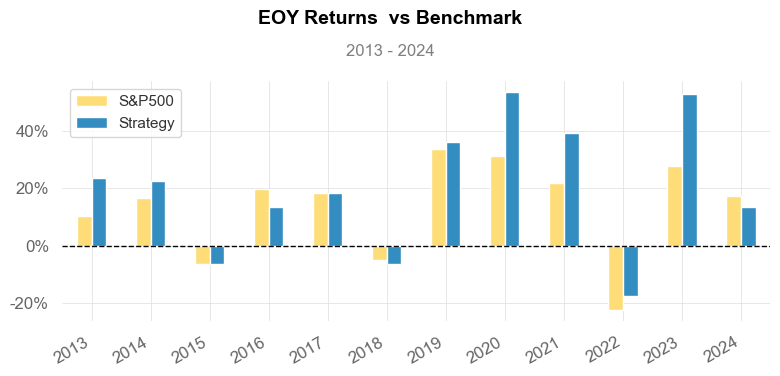

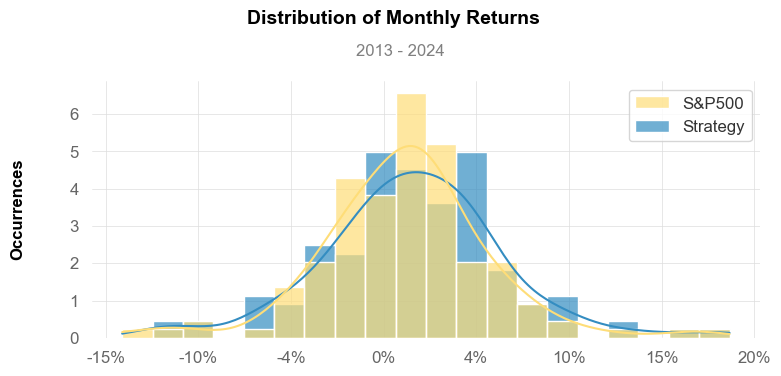

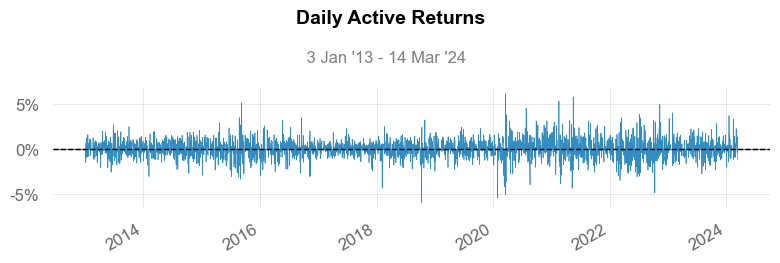

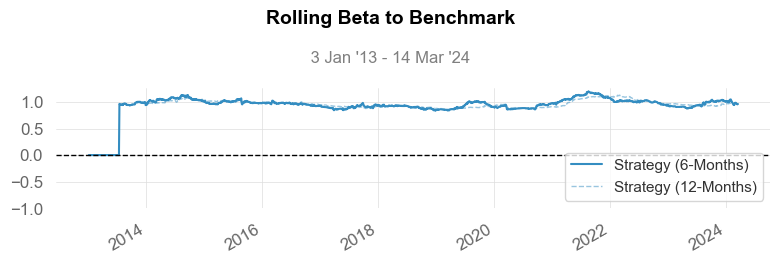

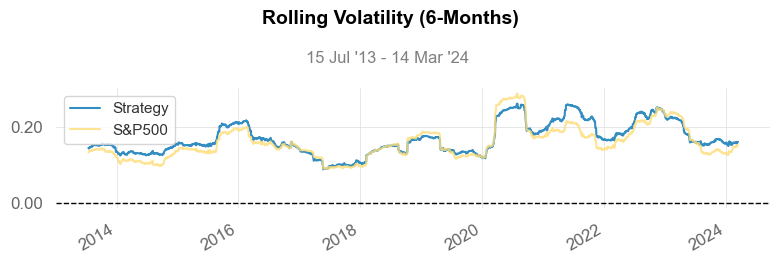

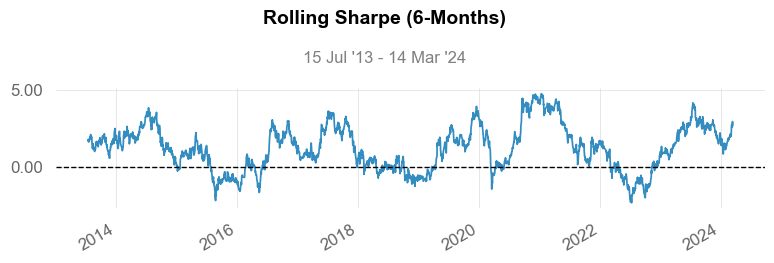

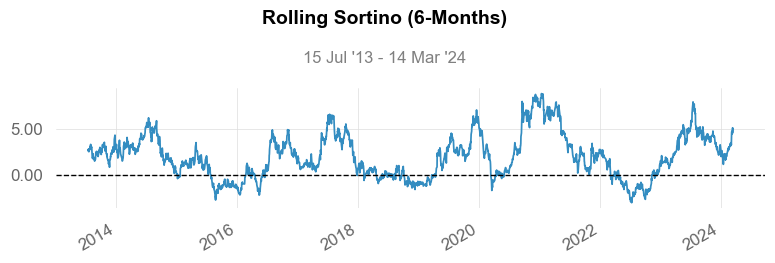

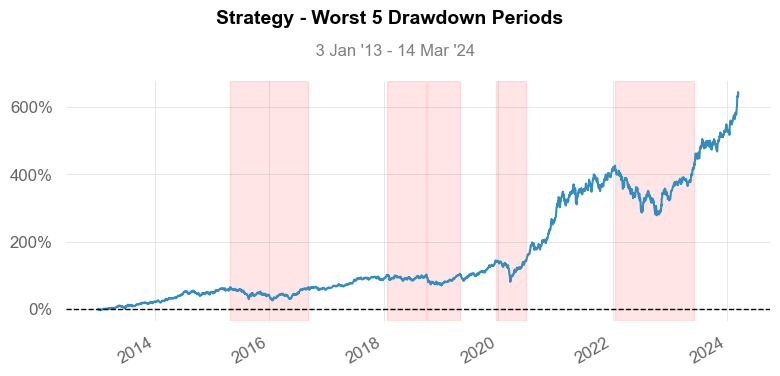

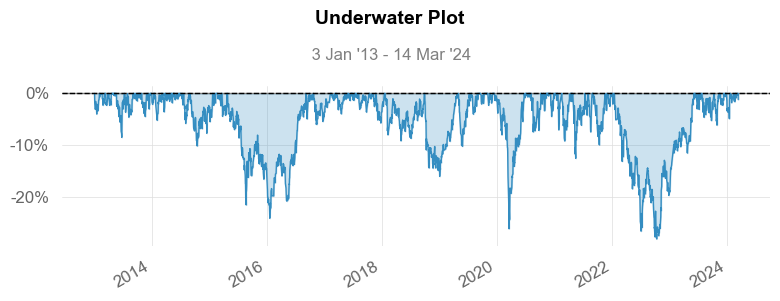

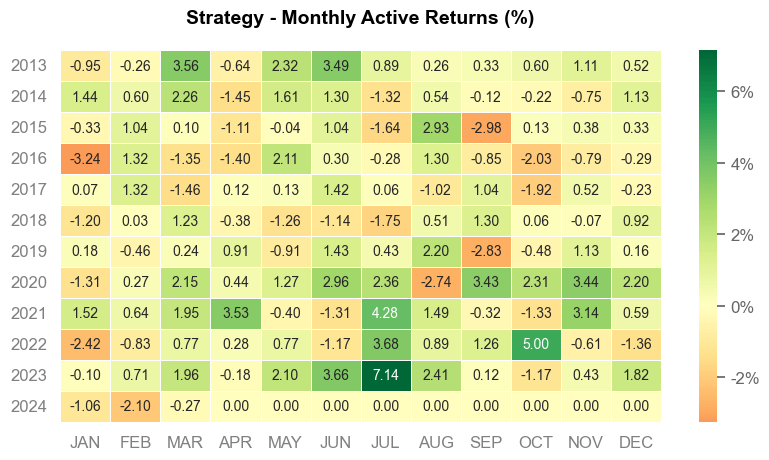

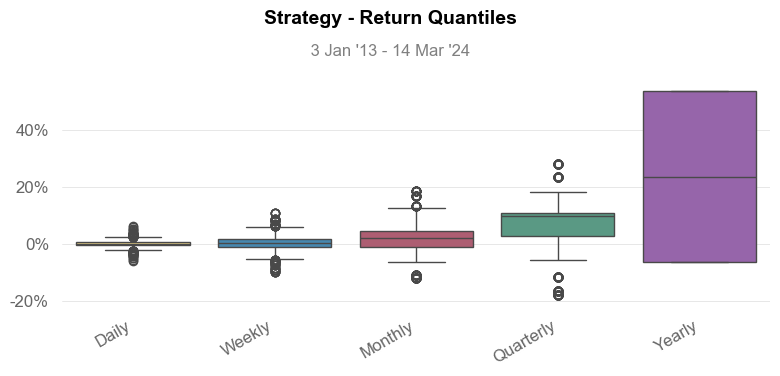

In [32]:
show_performance(bah,benchmark = data[benchmark_asset_name].pct_change().dropna())

# Performance of UCRP


c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2013-01-03   2013-01-03
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          301.4%       441.33%
CAGR﹪                     8.94%        10.97%

Sharpe                     0.87         1.05
Prob. Sharpe Ratio         99.79%       99.97%
Smart Sharpe               0.86         1.04
Sortino                    1.28         1.53
Smart Sortino              1.27         1.52
Sortino/√2                 0.9          1.08
Smart Sortino/√2           0.9          1.07
Omega                      1.2          1.2

Max Drawdown               -34.86%      -26.11%
Longest DD Days            749          689
Volatility (ann.)          16.24%       16.05%
R^2                        0.81         0.81
Information Ratio          0.02         0.02
Calmar             

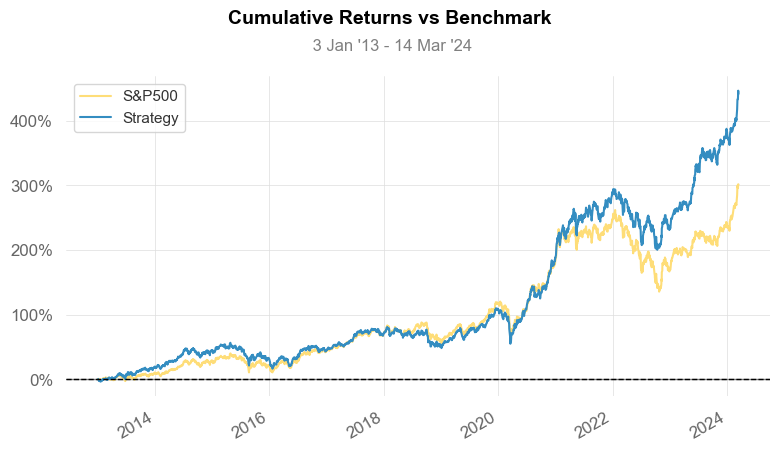

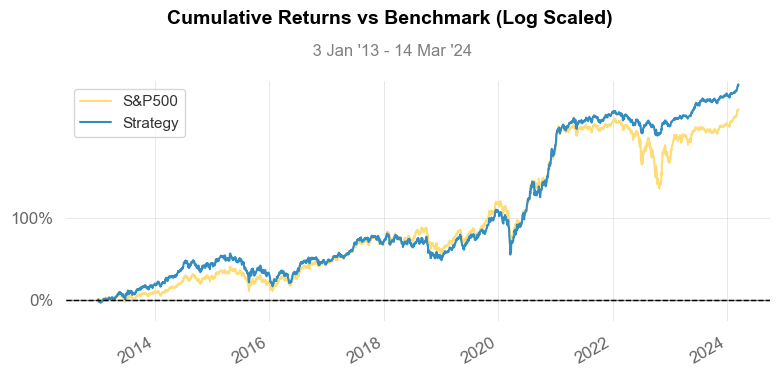

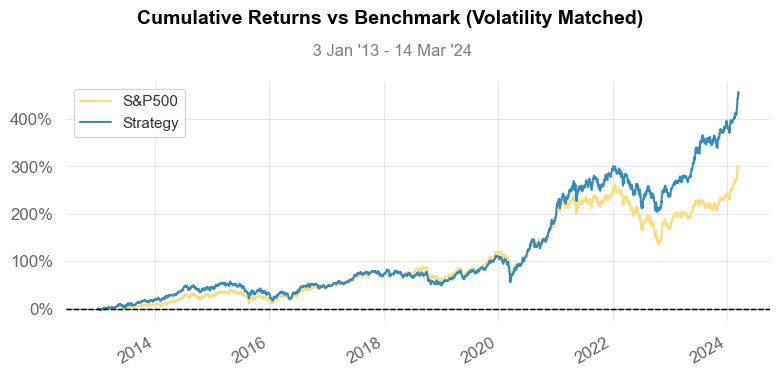

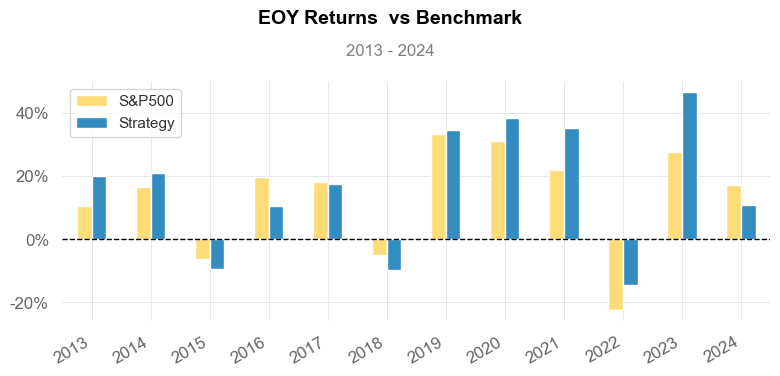

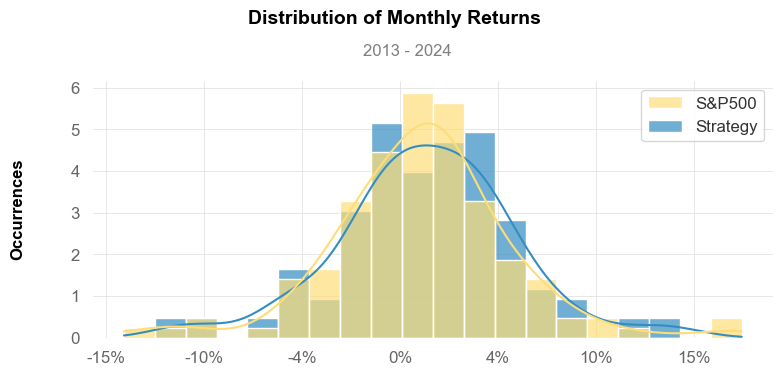

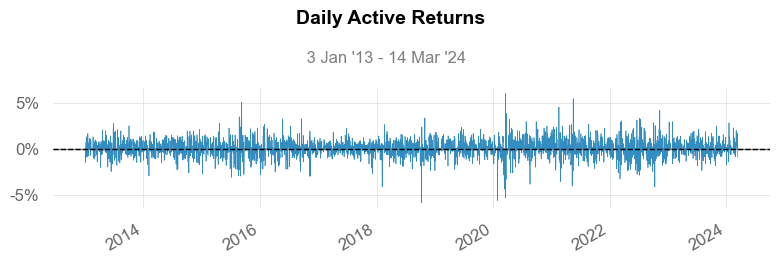

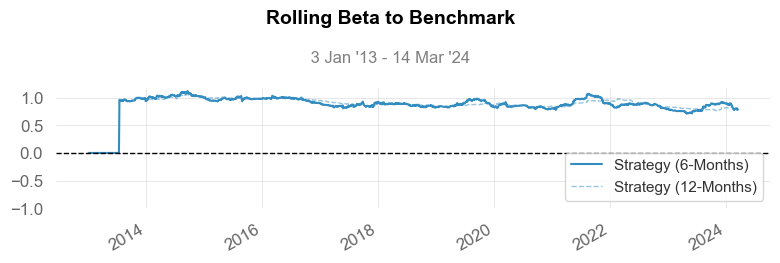

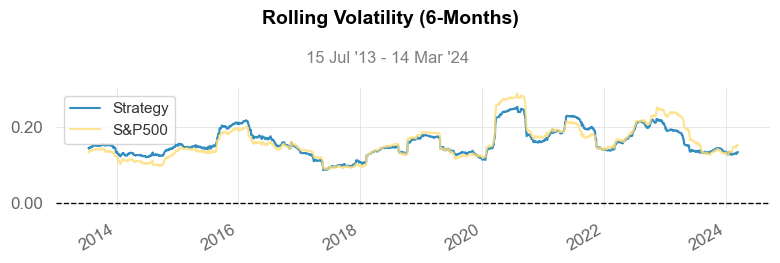

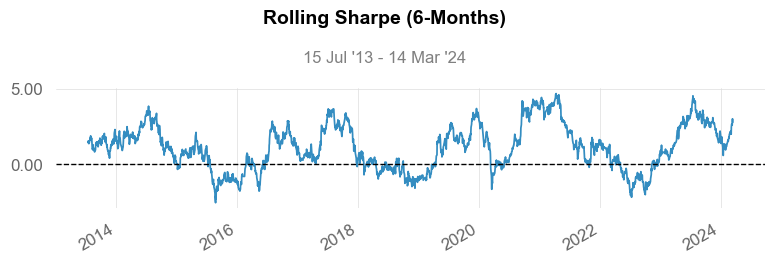

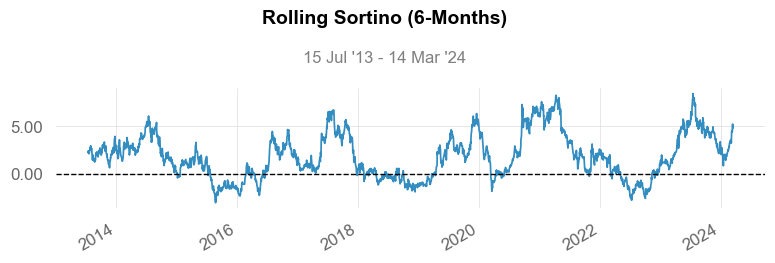

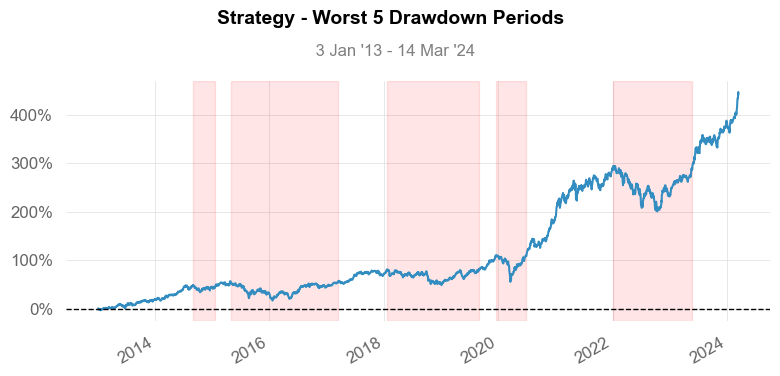

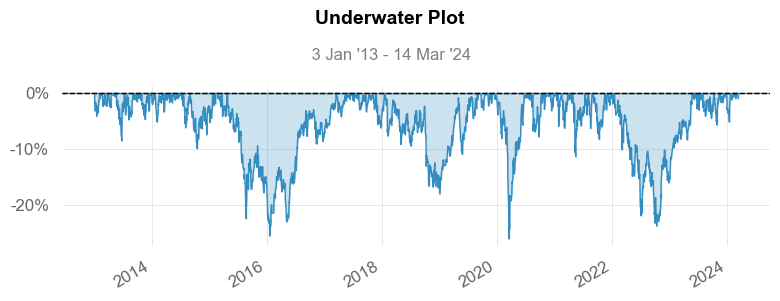

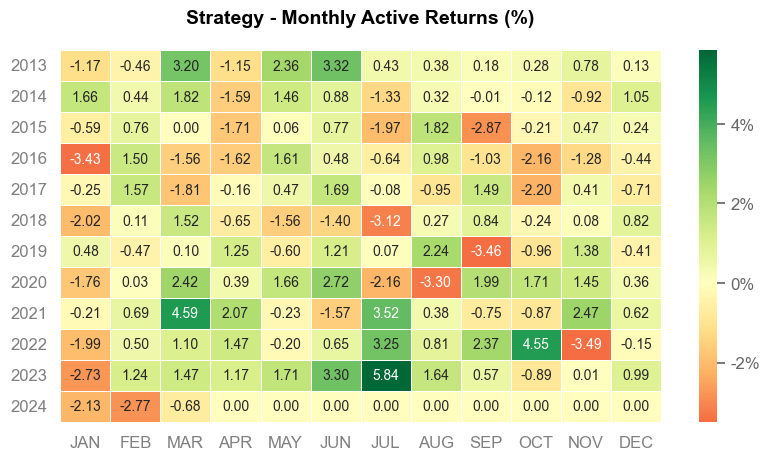

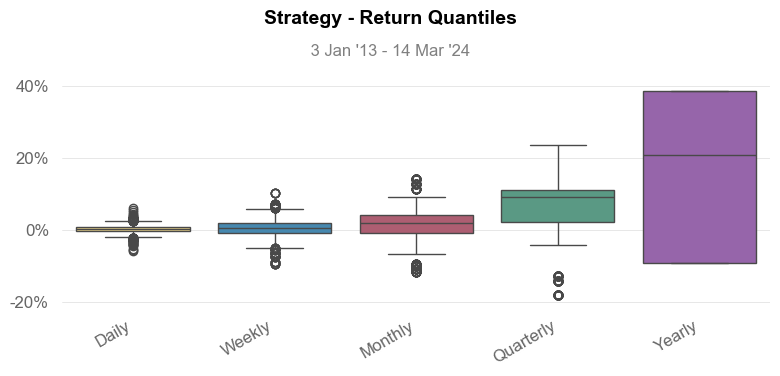

In [33]:
show_performance(ucrp,benchmark = data[benchmark_asset_name].pct_change().dropna())

# Performance of UP


c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2013-01-03   2013-01-03
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          301.4%       590.38%
CAGR﹪                     8.94%        12.65%

Sharpe                     0.87         1.21
Prob. Sharpe Ratio         99.79%       100.0%
Smart Sharpe               0.86         1.19
Sortino                    1.28         1.78
Smart Sortino              1.26         1.75
Sortino/√2                 0.9          1.26
Smart Sortino/√2           0.89         1.24
Omega                      1.23         1.23

Max Drawdown               -34.86%      -22.53%
Longest DD Days            749          400
Volatility (ann.)          16.24%       15.81%
R^2                        0.57         0.57
Information Ratio          0.03         0.03
Calmar            

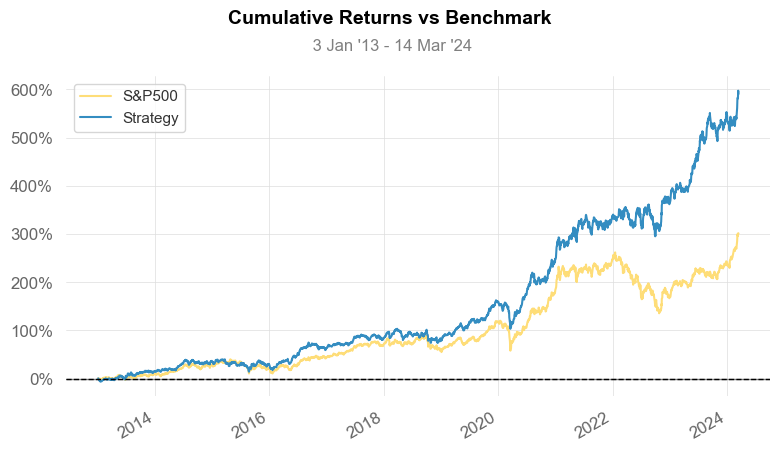

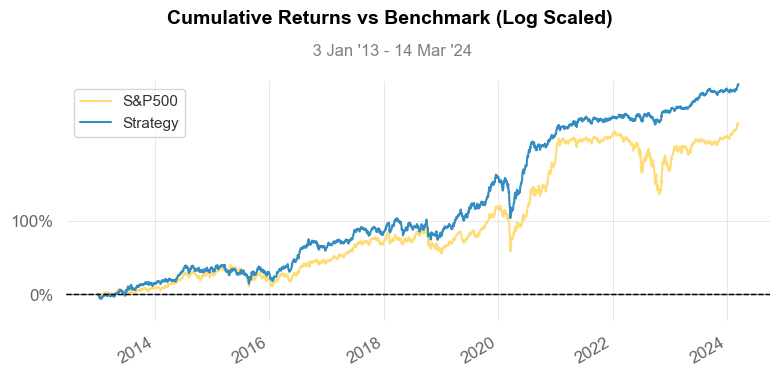

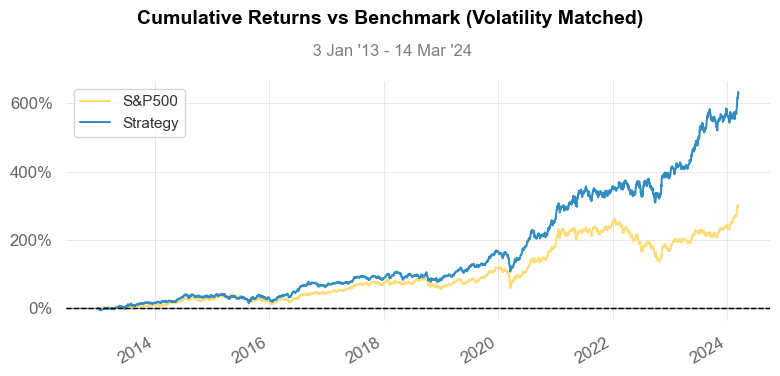

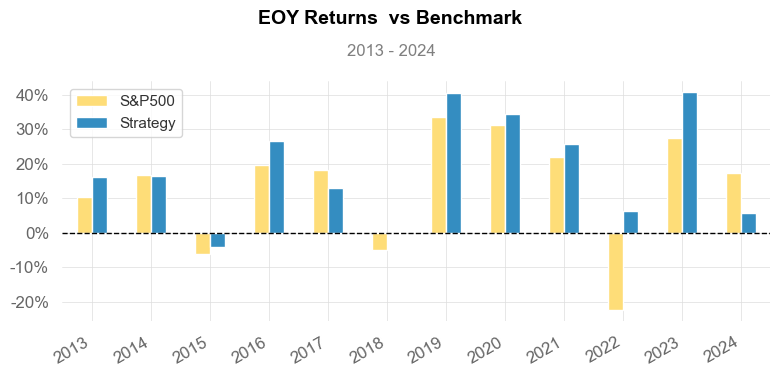

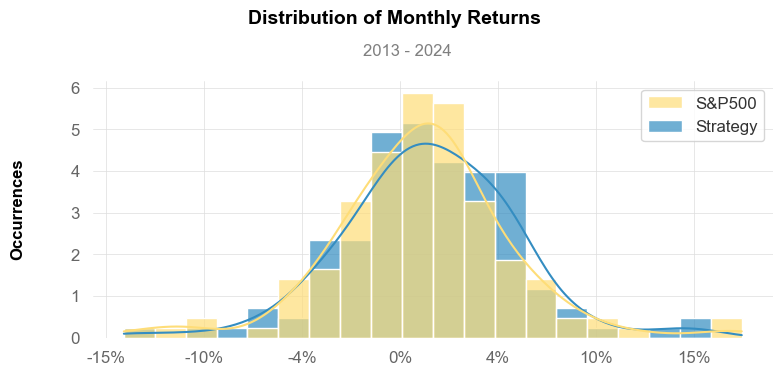

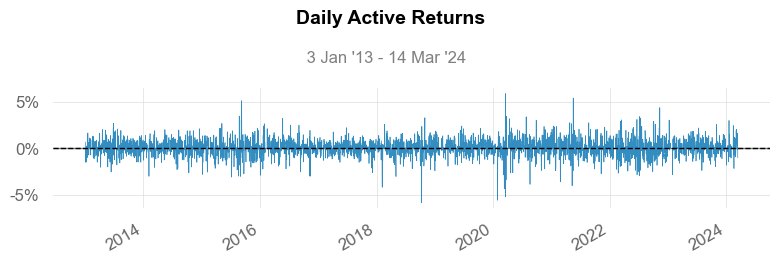

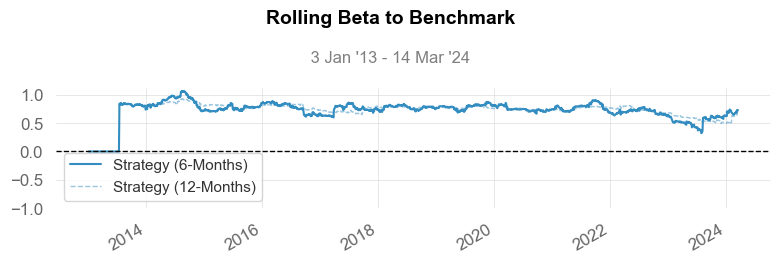

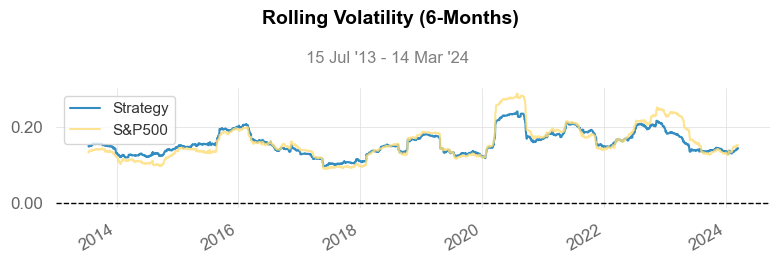

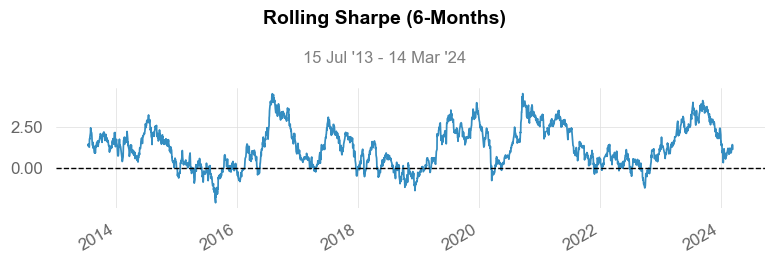

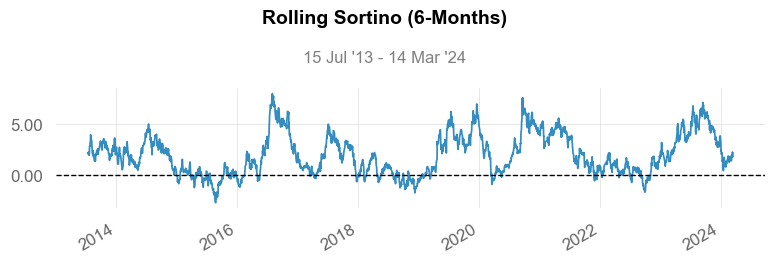

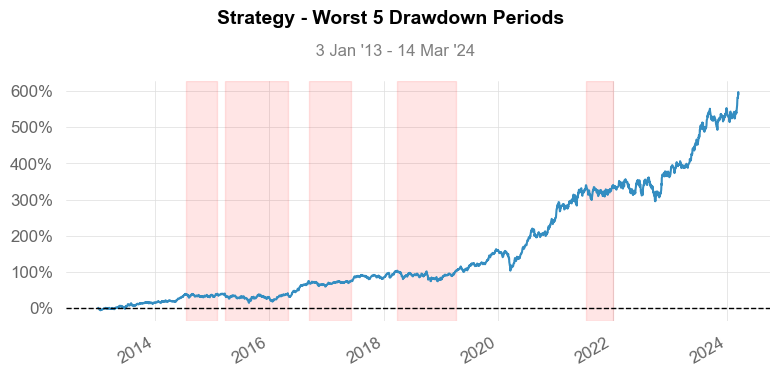

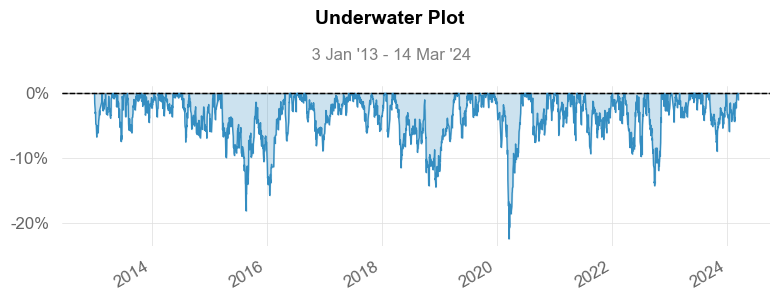

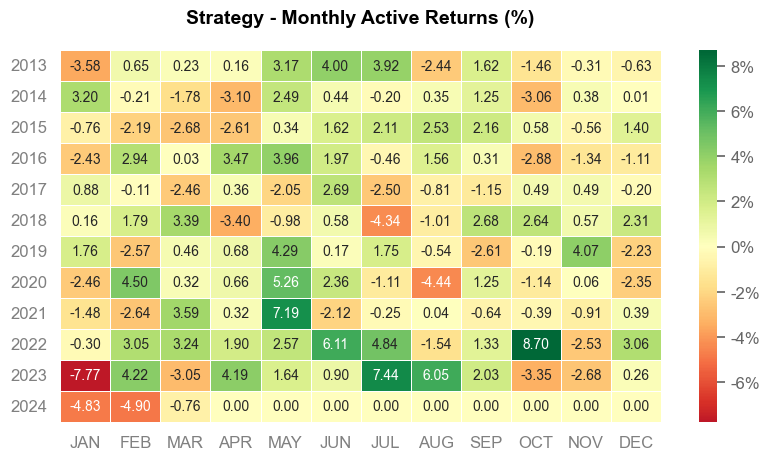

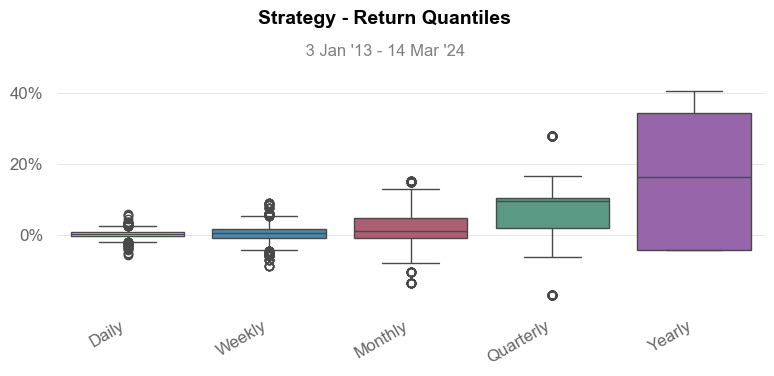

In [35]:
show_performance(up_dirichlet,benchmark = data[benchmark_asset_name].pct_change().dropna())

# Performance of Staged $\tilde{EG}(\alpha ,\eta)$



c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\林元鴻\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old be

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2013-01-03   2013-01-03
End Period                 2024-03-14   2024-03-14
Risk-Free Rate             0.0%         0.0%
Time in Market             96.0%        100.0%

Cumulative Return          301.4%       441.45%
CAGR﹪                     8.94%        10.97%

Sharpe                     0.87         1.05
Prob. Sharpe Ratio         99.79%       99.97%
Smart Sharpe               0.86         1.04
Sortino                    1.28         1.53
Smart Sortino              1.27         1.52
Sortino/√2                 0.9          1.08
Smart Sortino/√2           0.9          1.07
Omega                      1.2          1.2

Max Drawdown               -34.86%      -26.11%
Longest DD Days            749          689
Volatility (ann.)          16.24%       16.05%
R^2                        0.81         0.81
Information Ratio          0.02         0.02
Calmar             

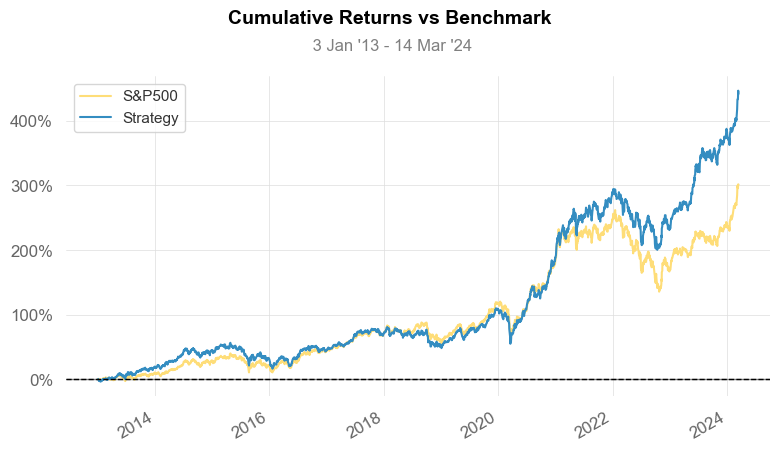

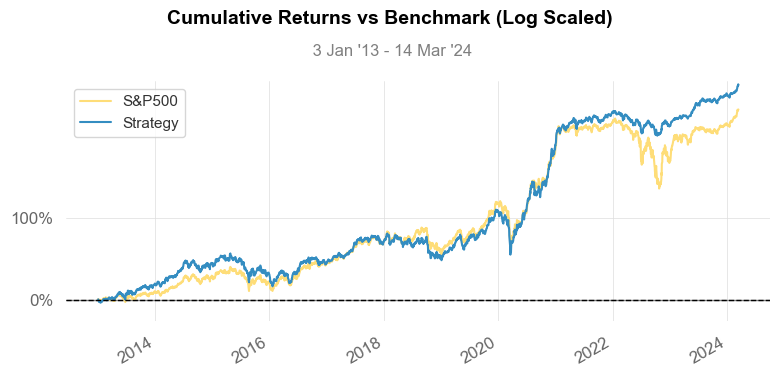

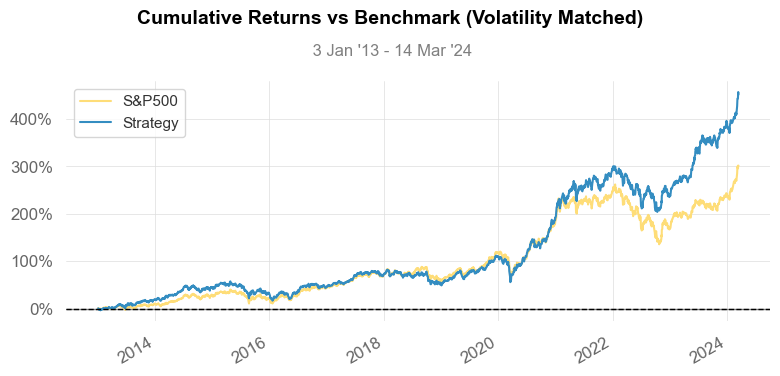

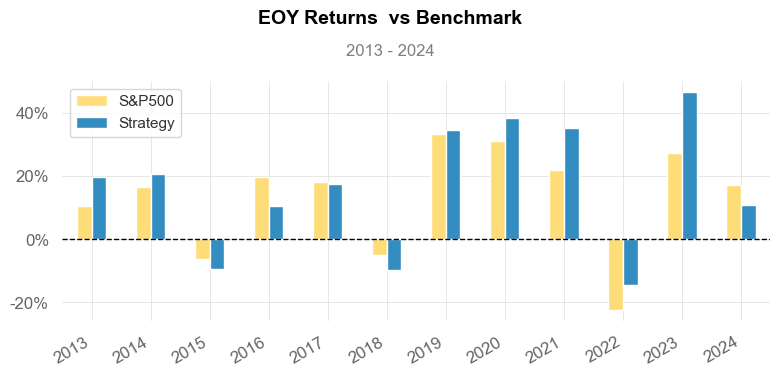

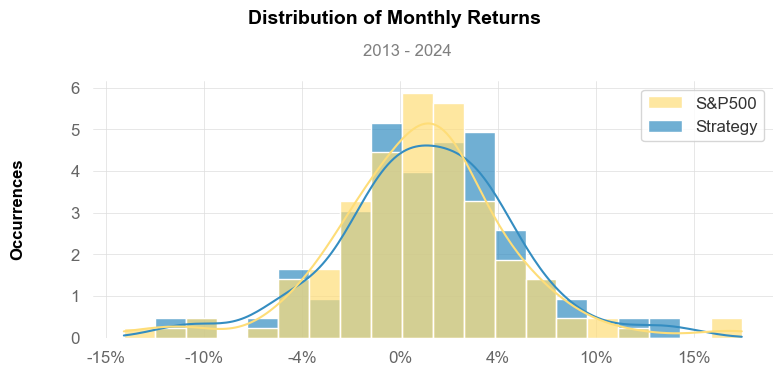

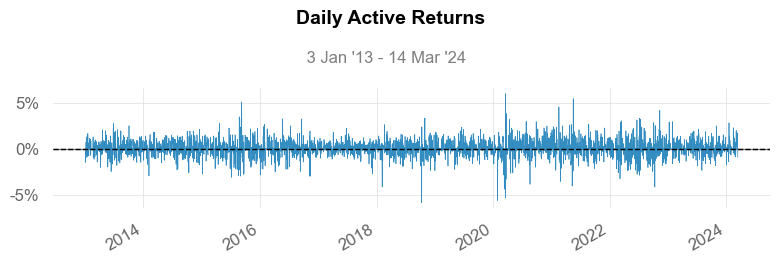

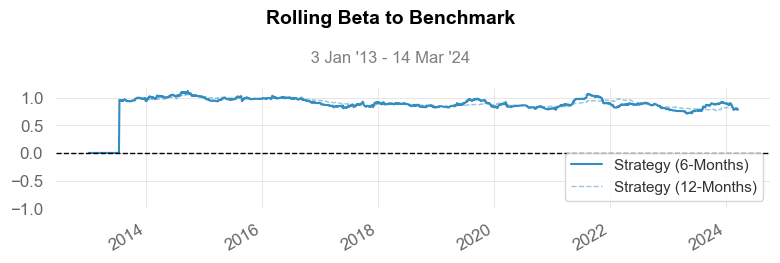

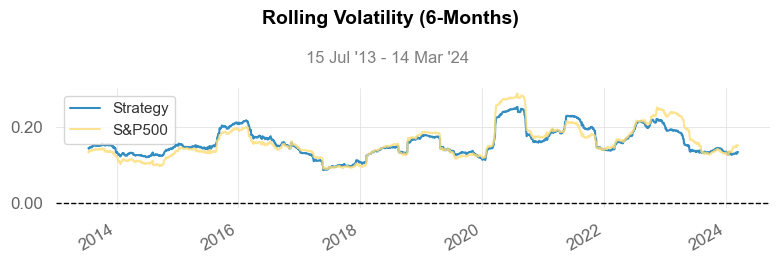

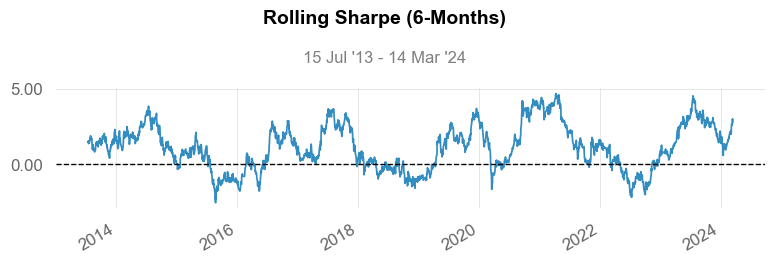

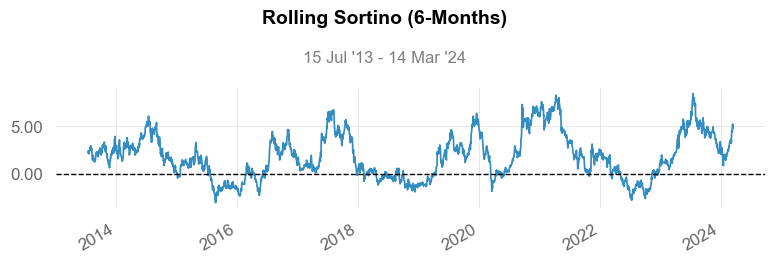

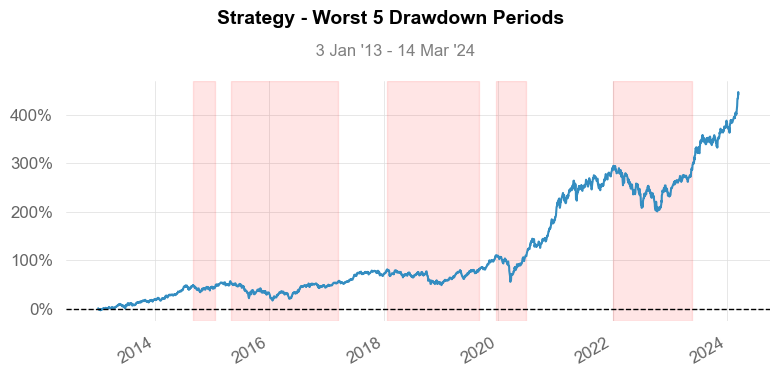

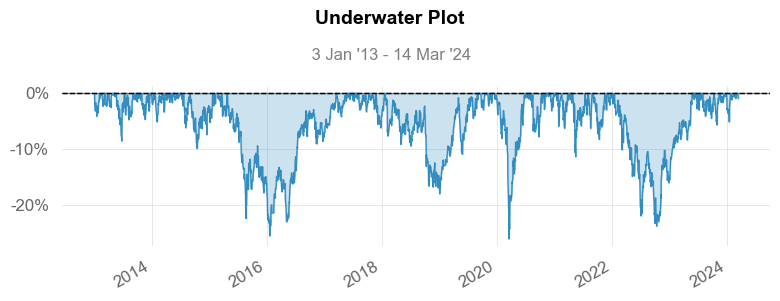

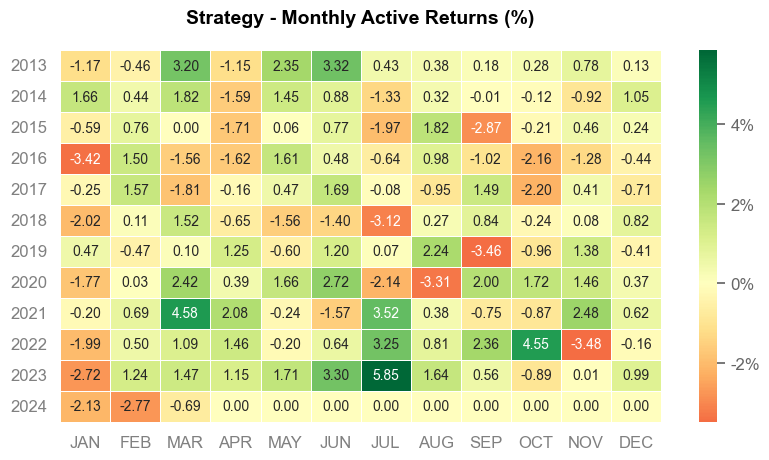

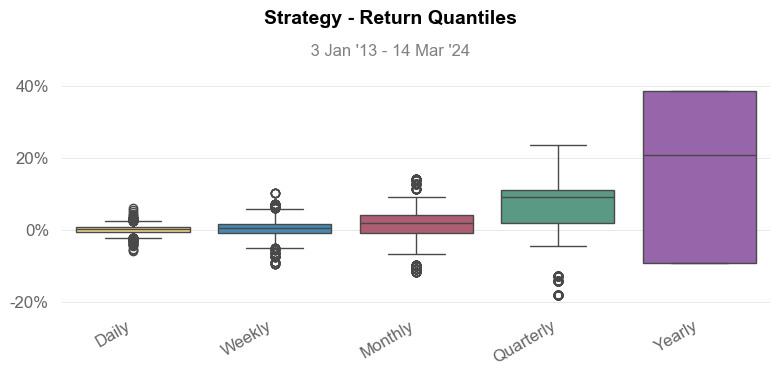

In [36]:
show_performance(smeg,benchmark = data[benchmark_asset_name].pct_change().dropna())

# References

- AVRIM BLUM, ADAM KALAI, School of Computer Science, Carnegie Mellon University, Pittsburgh, PA 15213, Universal Portfolios With and Without Transaction Costs

- DAVID P. HELMBOLD, ROBERT E. SCHAPIRE AND YORAM SINGER, AT&T Labs, MANFRED K. WARMUTH, Computer and Information Sciences, University of California, Santa Cruz, ON-LINE PORTFOLIO SELECTION USING MULTIPLICATIVE UPDATES

- github, Sudeep Raja, Online Portfolio Selection

- github, Marigold, Online Portfolio Selection